In [37]:
import numpy as np
import os
import sys
import warnings
import time

# Define paths to relevant modules
measure_sampling_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling')
trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees')
Benchmark_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Benchmark_value_Gausian')
awd_trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees')
CD_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density')
kmeans_meas_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Adapted_empirical_measure')
aot_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics')
FVI_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/FVI')


# Add paths to sys.path
for path in [measure_sampling_path, trees_path, Benchmark_path, awd_trees_path, CD_path, kmeans_meas_path, aot_path, FVI_path]:
    if path not in sys.path:
        sys.path.append(path)

from Build_trees_from_paths import *
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *
from Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from Gurobi_AOT import *
from Nested_Dist_Algo import compute_nested_distance
from CD_nonparam import *

from Gen_Path_and_AdaptedTrees import *
from mainfunctions import *
from measure import *
from normal_ot import *
from FVI_bench import *

from Extract_Sample_path_AOT import extract_sample_paths

from FVI import train_dqn_instance, train_dqn_instance_mult
from CD_knn_NerualNet import *

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from AEM_kMeans import empirical_k_means_measure, empirical_k_means_measure_new, empirical_k_means_measure_grid
from AEM_grid import empirical_grid_measure


import numpy as np
import random
import time
import matplotlib.pyplot as plt
import ot
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set up

In [38]:

def nearest_pd(A):
    """Find the nearest positive-definite matrix to A."""
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = V.T @ np.diag(s) @ V
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    # Ensure positive definiteness by adding a small identity matrix if needed.
    if is_pd(A3):
        return A3
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 0.5
    while not is_pd(A3):
        A3 += I * spacing * k
        k += 1
    return A3

def is_pd(B):
    """Return True if B is positive-definite."""
    try:
        np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

Sigma1 = np.array([
    [35,   30,   -3,   2,  -20],
    [30,   35,   3,   -6,   40],
    [-3,    33,   10,    3,   -2],
    [2,     -1.5,    3,    0.5,   0.25],
    [-20,   40,   -2,  0.25, 30]
])
Sigma1 = (Sigma1 + Sigma1.T) / 2  # ensure symmetry

# Covariance Matrix Sigma2:
# - Variances: [25, 5, 16, 3.2, 9] corresponding to std devs: 5, ~2.24, 4, ~1.79, 3.
# - Sparse, extreme off-diagonals: a strong negative tie between X1 and X3 and smaller interactions elsewhere.
Sigma2 = np.array([
    [25,    0,   -20,    0,    1.5],
    [0,     5,     0,  -0.4,    0],
    [-20,   0,    16,    0,   -1.2],
    [0,   -0.4,    0,   3.2,    0],
    [1.5,   0,   -1.2,    0,    9]
])
Sigma2 = (Sigma2 + Sigma2.T) / 2  # ensure symmetry


Sigma3 = np.array([
    [30,   15,    5,   10,  -20],
    [15,   25,   12,   -8,    5],
    [5,    12,   20,    7,   -3],
    [10,   -8,    7,   10,    4],
    [-20,   5,   -3,    4,   30]
])
Sigma3 = (Sigma3 + Sigma3.T) / 2  # ensure symmetry


# Adjust the covariance matrices to be positive-definite.
sigma1_pd = nearest_pd(Sigma1)
sigma2_pd = nearest_pd(Sigma2)
sigma3_pd = nearest_pd(Sigma3)


# Mean vector (zero for both)
mean = np.zeros(5)

# Number of samples.
n_samples = 30

# Draw 400 samples from each Gaussian distribution.
samples1 = np.random.multivariate_normal(mean, sigma1_pd, size=n_samples)
samples2 = np.random.multivariate_normal(mean, sigma2_pd, size=n_samples)
samples3 = np.random.multivariate_normal(mean, sigma3_pd, size=n_samples)


weights = np.ones(n_samples) / n_samples

# Prepend a zero to each sample to create a vector of length 6.
# Each sample is originally (5,), and we add a zero as the first element.
samples1_with_zero = np.hstack([np.zeros((n_samples, 1)), samples1])
samples2_with_zero = np.hstack([np.zeros((n_samples, 1)), samples2])
samples3_with_zero = np.hstack([np.zeros((n_samples, 1)), samples3])

# For demonstration, print the shape and the first sample.
print("Samples1 with zero shape:", samples1_with_zero.shape)
print("First sample (Sigma1):", samples1_with_zero[0])
print("Samples2 with zero shape:", samples2_with_zero.shape)
print("First sample (Sigma2):", samples2_with_zero[0])
print("Samples3 with zero shape:", samples3_with_zero.shape)
print("First sample (Sigma3):", samples3_with_zero[0])

print(sigma1_pd)
print(sigma2_pd)
print(sigma3_pd)


Samples1 with zero shape: (30, 6)
First sample (Sigma1): [ 0.          2.67397073 -5.34539902 -1.36167229  0.32867425 -7.34193148]
Samples2 with zero shape: (30, 6)
First sample (Sigma2): [ 0.         -1.74110778  2.01979151  1.39288623  0.29607841  1.4345084 ]
Samples3 with zero shape: (30, 6)
First sample (Sigma3): [  0.          20.90655241   8.9615314    7.89591912   5.32041329
 -12.5698823 ]
[[ 41.66833605  20.91176579   1.79830031   0.08452856 -11.93020331]
 [ 20.91176579  47.38629854  11.460426    -1.13941575  29.00172369]
 [  1.79830031  11.460426    13.4526883    1.62169406   3.80674214]
 [  0.08452856  -1.13941575   1.62169406   1.05021685  -2.06803931]
 [-11.93020331  29.00172369   3.80674214  -2.06803931  39.76579737]]
[[ 2.50000000e+01 -5.37519383e-17 -2.00000000e+01 -2.24087043e-20
   1.50000000e+00]
 [-5.37519383e-17  5.00000000e+00 -5.58688406e-16 -4.00000000e-01
   6.90742637e-16]
 [-2.00000000e+01 -5.58688406e-16  1.60000000e+01  3.26145406e-17
  -1.20000000e+00]
 [-2

## Visualisation

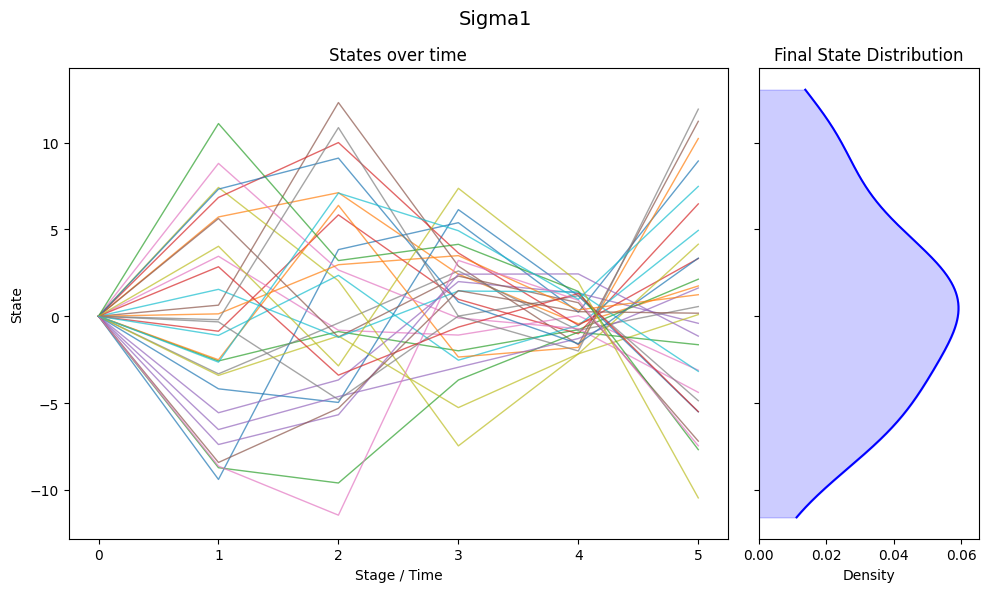

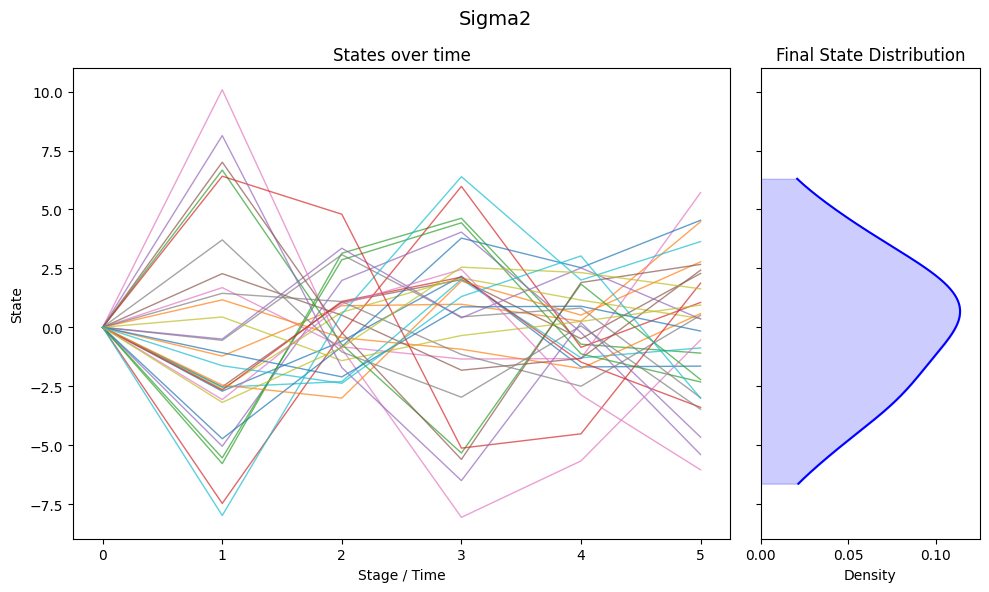

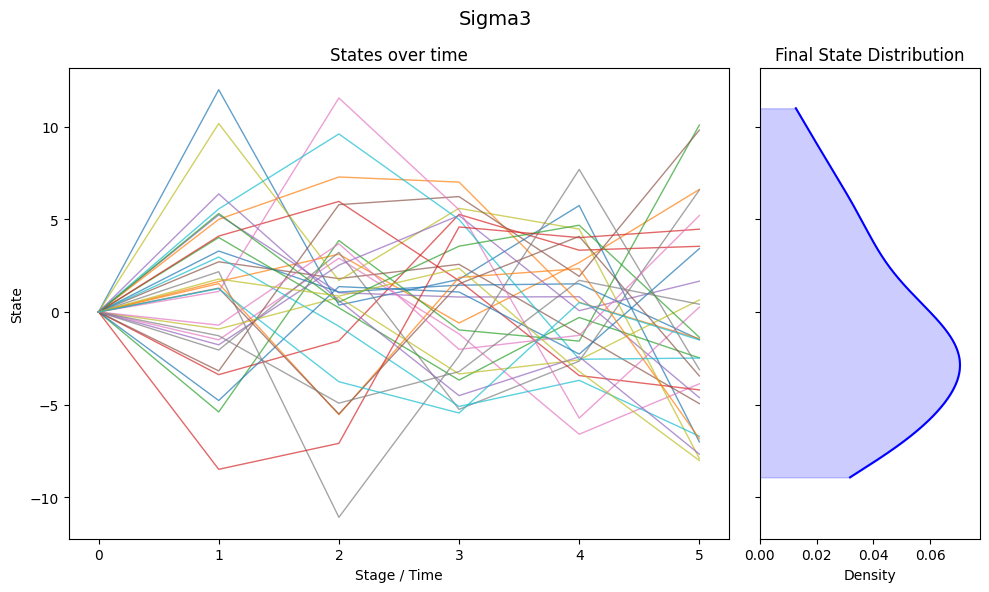

In [25]:
tree1 = build_tree_from_paths(samples1_with_zero, weights)
tree2 = build_tree_from_paths(samples2_with_zero, weights)
tree3 = build_tree_from_paths(samples3_with_zero, weights)

visualize_big_tree(tree1, title= "Sigma1")
visualize_big_tree(tree2, title= "Sigma2")
visualize_big_tree(tree3, title= "Sigma3")

## Let check how the different way to adapt those path works (visualisaiton):

In [ ]:
# kmeans
new_sample_paths1, new_weights1 =empirical_k_means_measure(samples1_with_zero, use_weights=True)
new_sample_paths2, new_weights2 = empirical_k_means_measure(samples2_with_zero, use_weights=True)
new_sample_paths3, new_weights3 = empirical_k_means_measure(samples3_with_zero, use_weights=True)

root1 = build_tree_from_paths(new_sample_paths1, new_weights1)
root2 = build_tree_from_paths(new_sample_paths2, new_weights2)
root3 = build_tree_from_paths(new_sample_paths3, new_weights3)


visualize_big_tree(root1, fig_size=(10,6), title="Adapted Kmeans Empirical Sigma1")
visualize_big_tree(root2, fig_size=(10,6), title="Adapted Kmeans Empirical Sigma2")
visualize_big_tree(root3, fig_size=(10,6), title="Adapted Kmeans Empirical Sigma3")


# kmeans_new
new_sample_paths1, new_weights1 = empirical_k_means_measure_new(samples1_with_zero, use_weights=True)
new_sample_paths2, new_weights2 = empirical_k_means_measure_new(samples2_with_zero, use_weights=True)
new_sample_paths3, new_weights3 = empirical_k_means_measure_new(samples3_with_zero, use_weights=True)

root1 = build_tree_from_paths(new_sample_paths1, new_weights1)
root2 = build_tree_from_paths(new_sample_paths2, new_weights2)
root3 = build_tree_from_paths(new_sample_paths2, new_weights3)


visualize_big_tree(root1, fig_size=(10,6), title="Adapted Kmeans_new Empirical Sigma1")
visualize_big_tree(root2, fig_size=(10,6), title="Adapted Kmeans_new Empirical Sigma2")
visualize_big_tree(root3, fig_size=(10,6), title="Adapted Kmeans_new Empirical Sigma3")


# kmeans_grid
new_sample_paths1, new_weights1 = empirical_k_means_measure_grid(samples1_with_zero, use_weights=True)
new_sample_paths2, new_weights2 = empirical_k_means_measure_grid(samples2_with_zero, use_weights=True)
new_sample_paths3, new_weights3 = empirical_k_means_measure_grid(samples3_with_zero, use_weights=True)

root1 = build_tree_from_paths(new_sample_paths1, new_weights1)
root2 = build_tree_from_paths(new_sample_paths2, new_weights2)
root3 = build_tree_from_paths(new_sample_paths3, new_weights3)


visualize_big_tree(root1, fig_size=(10,6), title="Adapted Kmeans_grid Empirical Sigma1")
visualize_big_tree(root2, fig_size=(10,6), title="Adapted Kmeans_grid Empirical Sigma2")
visualize_big_tree(root3, fig_size=(10,6), title="Adapted Kmeans_grid Empirical Sigma3")


# grid
new_sample_paths1, new_weights1 = empirical_grid_measure(samples1_with_zero, use_weights=True)
new_sample_paths2, new_weights2 = empirical_grid_measure(samples2_with_zero, use_weights=True)
new_sample_paths3, new_weights3 = empirical_grid_measure(samples3_with_zero, use_weights=True)

root1 = build_tree_from_paths(new_sample_paths1, new_weights1)
root2 = build_tree_from_paths(new_sample_paths2, new_weights2)
root3 = build_tree_from_paths(new_sample_paths3, new_weights3)


visualize_big_tree(root1, fig_size=(10,6), title="Adapted grid Empirical Sigma1")
visualize_big_tree(root2, fig_size=(10,6), title="Adapted grid Empirical Sigma2")
visualize_big_tree(root3, fig_size=(10,6), title="Adapted grid Empirical Sigma3")

## Benchmark values

In [ ]:
mean = np.zeros(5)

# Compute adapted Wasserstein squared distance
bench_val = adapted_wasserstein_squared(mean, sigma1_pd, mean, sigma2_pd)

print(bench_val)


# Compute adapted Wasserstein squared distance
bench_val = adapted_wasserstein_squared(mean, sigma1_pd, mean, sigma3_pd)

print(bench_val)

# Compute adapted Wasserstein squared distance
bench_val = adapted_wasserstein_squared(mean, sigma2_pd, mean, sigma3_pd)

print(bench_val)

## Convergence of adapted measure

grid
Time Steps: 6, Method: grid, Run 1/10 for sample size 200...
Time Steps: 6, Method: grid, Run 2/10 for sample size 200...
Time Steps: 6, Method: grid, Run 3/10 for sample size 200...
Time Steps: 6, Method: grid, Run 4/10 for sample size 200...
Time Steps: 6, Method: grid, Run 5/10 for sample size 200...
Time Steps: 6, Method: grid, Run 6/10 for sample size 200...
Time Steps: 6, Method: grid, Run 7/10 for sample size 200...
Time Steps: 6, Method: grid, Run 8/10 for sample size 200...
Time Steps: 6, Method: grid, Run 9/10 for sample size 200...
Time Steps: 6, Method: grid, Run 10/10 for sample size 200...
Time Steps: 6, Method: grid, Run 1/10 for sample size 500...
Time Steps: 6, Method: grid, Run 2/10 for sample size 500...
Time Steps: 6, Method: grid, Run 3/10 for sample size 500...
Time Steps: 6, Method: grid, Run 4/10 for sample size 500...
Time Steps: 6, Method: grid, Run 5/10 for sample size 500...
Time Steps: 6, Method: grid, Run 6/10 for sample size 500...
Time Steps: 6, Met

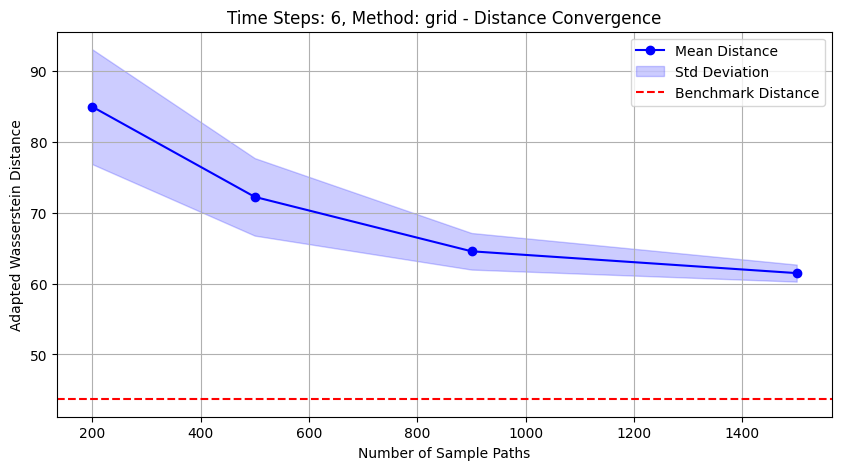

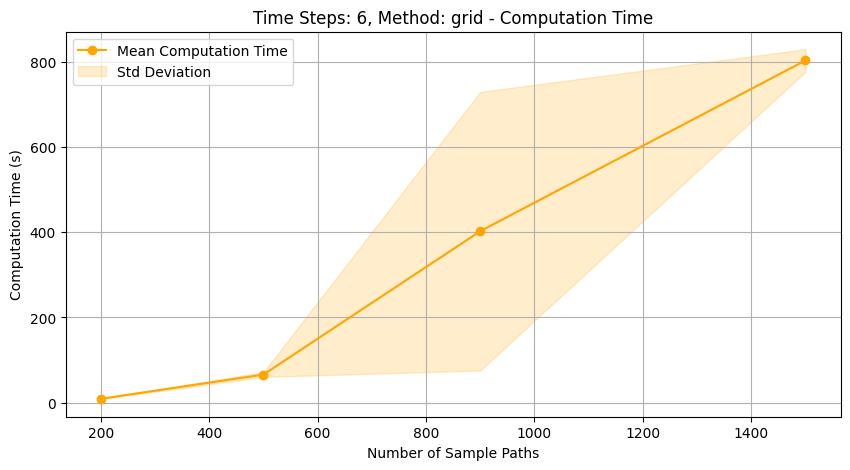

In [39]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the methods and time steps to loop over
method = "grid"
time_steps_list = [6]
n_runs = 10

# Define sample path sizes for each time step
sample_sizes = [200, 500, 900, 1500]

# Loop over each time step and method combination
for time_steps in time_steps_list:
    
    for value in [2]:

        Sigma_A = 0
        Sigma_B = 0

        if value == 1:
            Sigma_A = sigma1_pd
            Sigma_B = sigma2_pd
        elif value == 2:
            Sigma_A = sigma1_pd
            Sigma_B = sigma3_pd
        elif value == 3:
            Sigma_A = sigma2_pd
            Sigma_B = sigma3_pd
    

        print(method)
        # Arrays to store results for the current time_steps and method
        distances_all = np.zeros((len(sample_sizes), n_runs))
        times_all = np.zeros((len(sample_sizes), n_runs))
        
        t = time_steps - 1
        
        distance_squared = adapted_wasserstein_squared(mean, Sigma_A, mean, Sigma_B)
        
        # Loop over each sample size and run n_runs for statistics
        for i, num_paths in enumerate(sample_sizes):
            for run_idx in range(n_runs):
                print(f"Time Steps: {time_steps}, Method: {method}, Run {run_idx+1}/{n_runs} for sample size {num_paths}...")
                
                
                samplesA = np.random.multivariate_normal(mean, Sigma_A, size=num_paths)
                samplesB = np.random.multivariate_normal(mean, Sigma_B, size=num_paths)

                samplesA_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesA])
                samplesB_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesB])

                

                new_sample_pathsA, new_weightsA = empirical_grid_measure(samplesA_with_zero, use_weights=True)
                new_sample_pathsB, new_weightsB = empirical_grid_measure(samplesB_with_zero, use_weights=True)  #### Changed this
                tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
                tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)
                
                # Compute the nested (adapted optimal transport) distance and timing
                max_depth = get_depth(tree2)
                start_time = time.time()
                distance_pot = compute_nested_distance(
                    tree1, tree2, max_depth, 
                    method="solver_lp_pot", 
                    return_matrix=False, 
                    lambda_reg=0, 
                    power=2
                )
                elapsed_time_pot = time.time() - start_time
                
                # Adjust distance by subtracting the initial difference in squares (if needed)
                distance_pot -= (0 - 0) ** 2
                
                # Store the computed distance and time
                distances_all[i, run_idx] = distance_pot
                times_all[i, run_idx] = elapsed_time_pot
        
        # Compute statistics over runs
        distances_mean = distances_all.mean(axis=1)
        distances_std = distances_all.std(axis=1)
        times_mean = times_all.mean(axis=1)
        times_std = times_all.std(axis=1)
        
        # ---------------------------------------------------------
        # PLOT 1: Distance convergence with mean ± std band
        # ---------------------------------------------------------
        plt.figure(figsize=(10, 5))
        plt.plot(sample_sizes, distances_mean, marker="o", color="blue", label="Mean Distance")
        plt.fill_between(
            sample_sizes, 
            distances_mean - distances_std, 
            distances_mean + distances_std, 
            color="blue", alpha=0.2, label="Std Deviation"
        )
        plt.axhline(y=distance_squared, color="red", linestyle="--", label="Benchmark Distance")
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Adapted Wasserstein Distance")
        plt.title(f"Time Steps: {time_steps}, Method: {method} - Distance Convergence")
        plt.legend()
        plt.grid()
        plt.show()
        
        # ---------------------------------------------------------
        # PLOT 2: Computation time with mean ± std band
        # ---------------------------------------------------------
        plt.figure(figsize=(10, 5))
        plt.plot(sample_sizes, times_mean, marker="o", color="orange", label="Mean Computation Time")
        plt.fill_between(
            sample_sizes, 
            times_mean - times_std, 
            times_mean + times_std, 
            color="orange", alpha=0.2, label="Std Deviation"
        )
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Computation Time (s)")
        plt.title(f"Time Steps: {time_steps}, Method: {method} - Computation Time")
        plt.legend()
        plt.grid()
        plt.show()

## lets check how conditional density estimation works on those samples

Training progress: 0/1499
Training progress: 100/1499
Training progress: 300/1499
Training progress: 400/1499
Training progress: 500/1499
Training progress: 600/1499
Training progress: 700/1499
Training progress: 800/1499
Training progress: 900/1499
Training progress: 1000/1499
Training progress: 1100/1499
Training progress: 1200/1499
Training progress: 1300/1499
Training progress: 1400/1499
Training took 23.88 seconds.
Number of NaN losses encountered: 125


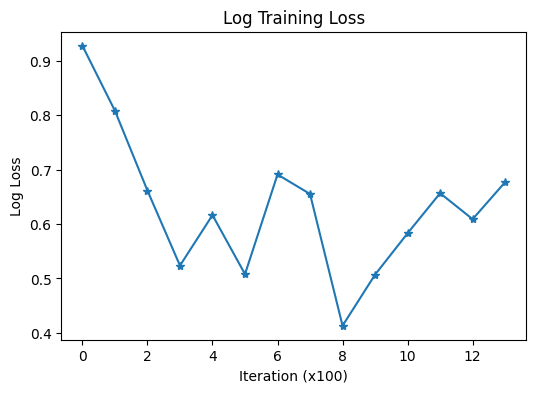

Trained estimator for k = 2. Number of NaN losses: 125
Results for x0:
----------------------------------------
x0 (List of Points):
[ 2.06918374 -4.74607572 -1.65534699  2.16896707]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[-1.6449896  0.8823902]

Weights (weights_est):
[0.5 0.5]


Real Mean and Standard Deviation:
----------------------------------------
Mean (cond_mean): 0.11380510590501414
Standard Deviation (cond_std): 2.9862183443278227
Results for x0:
----------------------------------------
x0 (List of Points):
[ 4.9203525   0.23673955 -3.936282    1.8897458 ]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[-0.33883178  1.8589927 ]

Weights (weights_est):
[0.5 0.5]


Real Mean and Standard Deviation:
----------------------------------------
Mean (cond_mean): 0.27061938752126735
Standard Deviation (cond_std): 2.9862183443278227
Results for x0:
---------

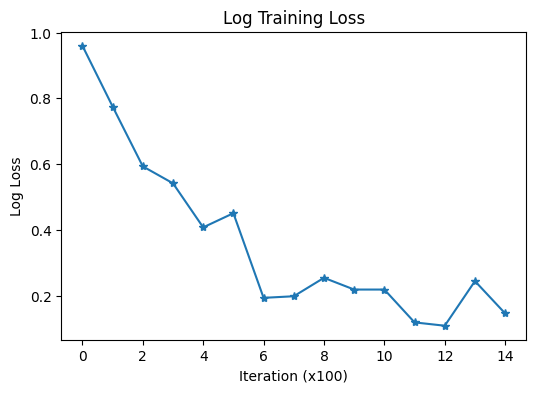

Trained estimator for k = 4. Number of NaN losses: 0
Results for x0:
----------------------------------------
x0 (List of Points):
[ 2.06918374 -4.74607572 -1.65534699  2.16896707]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[ 2.4355044   0.24695547  0.78313    -1.9968894 ]

Weights (weights_est):
[0.25 0.25 0.25 0.25]


Real Mean and Standard Deviation:
----------------------------------------
Mean (cond_mean): 0.11380510590501414
Standard Deviation (cond_std): 2.9862183443278227
Results for x0:
----------------------------------------
x0 (List of Points):
[ 4.9203525   0.23673955 -3.936282    1.8897458 ]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[ 0.9493439  1.5543734  2.1344023 -1.6070307]

Weights (weights_est):
[0.25 0.25 0.25 0.25]


Real Mean and Standard Deviation:
----------------------------------------
Mean (cond_mean): 0.27061938752126735
Standar

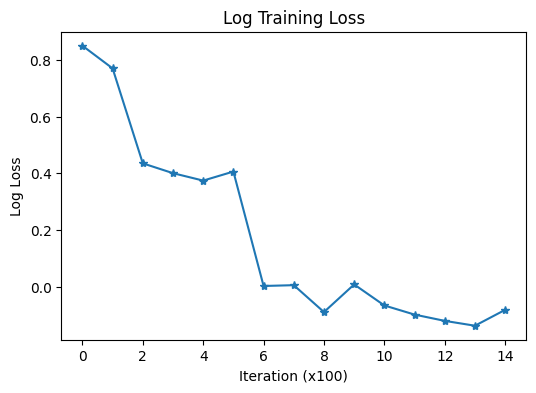

Trained estimator for k = 6. Number of NaN losses: 1
Results for x0:
----------------------------------------
x0 (List of Points):
[ 2.06918374 -4.74607572 -1.65534699  2.16896707]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[-1.3303034 -0.589708   2.096589  -3.2852032  3.162685   1.9622267]

Weights (weights_est):
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


Real Mean and Standard Deviation:
----------------------------------------
Mean (cond_mean): 0.11380510590501414
Standard Deviation (cond_std): 2.9862183443278227
Results for x0:
----------------------------------------
x0 (List of Points):
[ 4.9203525   0.23673955 -3.936282    1.8897458 ]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[-0.9863389  1.5811236  1.6085882 -2.417884   3.8544188  1.4030608]

Weights (weights_est):
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.

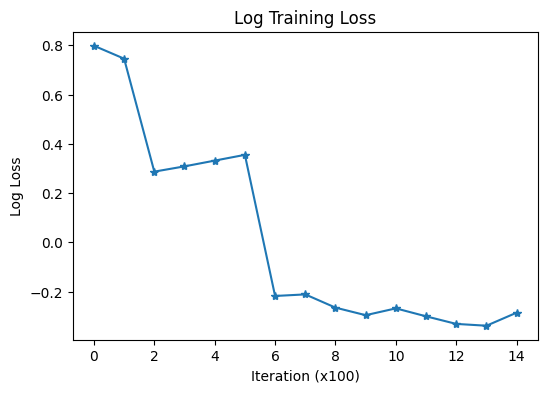

Trained estimator for k = 8. Number of NaN losses: 0
Results for x0:
----------------------------------------
x0 (List of Points):
[ 2.06918374 -4.74607572 -1.65534699  2.16896707]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[-1.3944067  0.3614908  3.6423054 -2.3219247  3.4009266  1.6058522
 -2.1229527 -0.5710877]

Weights (weights_est):
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


Real Mean and Standard Deviation:
----------------------------------------
Mean (cond_mean): 0.11380510590501414
Standard Deviation (cond_std): 2.9862183443278227
Results for x0:
----------------------------------------
x0 (List of Points):
[ 4.9203525   0.23673955 -3.936282    1.8897458 ]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[ 0.11004785  1.6114187   3.441196   -2.743274    3.0984235   1.5973644
 -0.8368529  -0.85049105]

Weights (weights_est):
[0.125 0.125 0.125 0.12

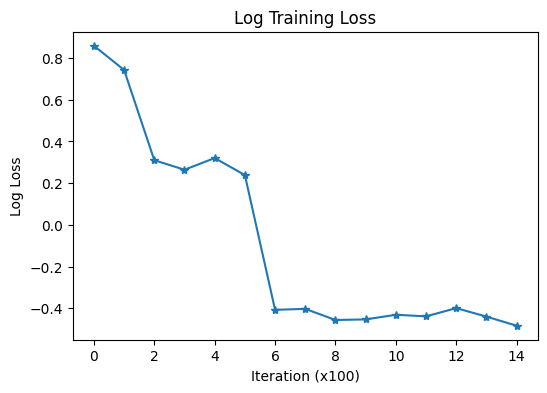

Trained estimator for k = 10. Number of NaN losses: 0
Results for x0:
----------------------------------------
x0 (List of Points):
[ 2.06918374 -4.74607572 -1.65534699  2.16896707]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[-2.3481061   3.9350567   1.3207583  -3.67154    -0.55884343 -0.6224801
 -0.09094282  2.6422772   0.25444472  2.726914  ]

Weights (weights_est):
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Real Mean and Standard Deviation:
----------------------------------------
Mean (cond_mean): 0.11380510590501414
Standard Deviation (cond_std): 2.9862183443278227
Results for x0:
----------------------------------------
x0 (List of Points):
[ 4.9203525   0.23673955 -3.936282    1.8897458 ]


Estimated Support Points and Weights:
----------------------------------------
Support Points (y_est_np):
[-1.7150648   3.477488    2.6281579  -3.196288   -1.0532031   0.38235313
 -0.38703352  2.6333027   2.228981    2.2903502 

In [27]:
from scipy.stats import norm

def compute_true_conditional(z_obs, Sigma):
    """
    Given an observation z_obs = [x1, x2, x3, x4] and a 5x5 covariance matrix Sigma,
    compute the conditional distribution of x5 given z_obs.
    Returns:
      cond_mean: scalar, the conditional mean
      cond_var: scalar, the conditional variance
    """
    # In our full vector x = [x1, x2, x3, x4, x5],
    # let z correspond to indices 0,1,2,3 and y = x5 (index 4)
    indices_z = [0, 1, 2, 3]
    index_y = 4

    Sigma_zz = Sigma[np.ix_(indices_z, indices_z)]
    Sigma_yz = Sigma[index_y, indices_z].reshape(1, -1)  # shape (1,4)
    Sigma_yy = Sigma[index_y, index_y]  # scalar

    Sigma_zz_inv = np.linalg.inv(Sigma_zz)
    cond_mean = (Sigma_yz @ Sigma_zz_inv @ z_obs.reshape(-1, 1)).item()
    cond_var = Sigma_yy - (Sigma_yz @ Sigma_zz_inv @ Sigma_yz.T).item()
    return cond_mean, cond_var


def compute_w2_squared(discrete_support, discrete_weights, true_support, true_weights):
    """
    Compute squared 2-Wasserstein distance between two discrete measures.
    discrete_support: 1D numpy array of support points (length m)
    discrete_weights: 1D numpy array of weights (length m, summing to 1)
    true_support: 1D numpy array of support points for the true measure (length n)
    true_weights: 1D numpy array of weights for the true measure (length n, summing to 1)
    """
    # Compute the squared Euclidean cost matrix between the supports.
    M = (discrete_support[:, None] - true_support[None, :])**2
    # ot.emd2 returns the squared Wasserstein distance
    return ot.emd2(discrete_weights, true_weights, M)



num_paths = 3000
# Draw 3000 samples (each is a 5-dimensional vector) and prepend a deterministic 0,
# so that each sample path is of length 6: [0, x1, x2, x3, x4, x5]
samplesA = np.random.multivariate_normal(mean, sigma2_pd, size=num_paths)

# --- Prepare Data for Training the Conditional Density Estimator ---
# We use entries 1 to 4 (indices 1:5) as input (X) and entry 5 (index 5) as output (Y).
t = 3
X = samplesA[:, 0:t+1]   # shape (num_paths, 4)
Y = samplesA[:, t+1]       # shape (num_paths,)

# Optionally, combine X and Y into a single data array if needed.
data = np.concatenate([X, Y.reshape(-1, 1)], axis=1)

# Convert to torch tensor.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

# --- Training and Evaluation ---
# (Assume you have defined your function train_conditional_density which returns an estimator
# with an attribute 'atomnet' that, given an input x0 (a 4-dimensional vector), outputs k discrete points.)
#
# For evaluation we define a list of conditioning inputs (x0_values), where each x0 is a 4-dim vector.
x0_values = [X[0], X[50], X[1000], X[1500]]
results = {tuple(x0): {} for x0 in x0_values}  # keys as tuples for immutability

k_values = list(range(2, 11, 2))  # e.g. 2, 4, 6, 8, 10

# --- Main Loop over k ---
for k in k_values:
    # Train the conditional density estimator for current k.
    # (train_conditional_density should be defined in your code.)
    estimator, loss_hist, n_nan = train_conditional_density(
        data_tensor, d_X=4, d_Y=1, k=k,
        n_iter=1500, n_batch=100, lr=1e-3, nns_type=' ', Lip = True, Print_res = True
    )
    
    estimator.atomnet.to(device)
    estimator.atomnet.eval()
    print(f"Trained estimator for k = {k}. Number of NaN losses: {n_nan}")
    
    for x0 in x0_values:
        # x0 is a 4-dimensional numpy array (conditioning input)
        with torch.no_grad():
            # Make sure x0 is of shape [1,4]
            x0_tensor = torch.tensor(x0.reshape(1, -1), dtype=torch.float32, device=device)
            # The estimator outputs k points (discrete support) for the conditional distribution of x5.
            y_est = estimator.atomnet(x0_tensor)  # assumed shape [1, k]
        y_est_np = y_est.cpu().numpy().flatten()
        weights_est = np.ones(k) / k
        
        # Now compute the true conditional distribution parameters for x5 given x0.
        cond_mean, cond_var = compute_true_conditional(np.array(x0), sigma2_pd)
        cond_std = np.sqrt(cond_var)
        
        # Create a grid for the true measure. For example, use a window of ±5 around cond_mean.
        y_min = cond_mean - 5
        y_max = cond_mean + 5
        y_grid = np.linspace(y_min, y_max, 800)
        dx = y_grid[1] - y_grid[0]


        # Print the point x0
        print("Results for x0:")
        print("-" * 40)
        print("x0 (List of Points):")
        print(x0)
        print("\n")

        # Print the estimated support points and weights
        print("Estimated Support Points and Weights:")
        print("-" * 40)
        print("Support Points (y_est_np):")
        print(y_est_np)
        print("\nWeights (weights_est):")
        print(weights_est)
        print("\n")

        # Print the real mean and standard deviation
        print("Real Mean and Standard Deviation:")
        print("-" * 40)
        print(f"Mean (cond_mean): {cond_mean}")
        print(f"Standard Deviation (cond_std): {cond_std}")



## TEST WITH FVI BAD RESULT

In [ ]:
# Number of runs
num_runs = 10

# Store results
final_values = []
val_histories = []
loss_histories = []

num_paths = 3000

time_steps = 6

# Run the function multiple times
for i in range(num_runs):
    print("-----------------------------------------------")
    print(f"Run: {i:.4f}")
    samplesA = np.random.multivariate_normal(mean, sigma1_pd, size=num_paths)
    samplesB = np.random.multivariate_normal(mean, sigma2_pd, size=num_paths)

    samplesA_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesA])
    samplesB_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesB])
    final_value, val_hist, loss_hist = train_dqn_instance_mult(
        x_dim=1, y_dim=1, time_horizon=time_steps-1,
        samplepath_x=samplesA_with_zero, samplepath_y=samplesB_with_zero,
        n_opt=50, in_sample_size=10,
        device=device, discount=1, mem_size=3000, trunc_flag=True, n_iter = 750
    )
    
    final_values.append(final_value)
    val_histories.append(val_hist)
    loss_histories.append(loss_hist)

# Compute statistics
final_values = np.array(final_values)
mean_final_value = np.mean(final_values)
std_final_value = np.std(final_values)


# Print results
print(f"Average Final Value: {mean_final_value:.4f}")
print(f"Standard Deviation: {std_final_value:.4f}")
print(f"Comparison with distance_squared: {distance_squared:.4f}")

### Build a tree from sigma 2

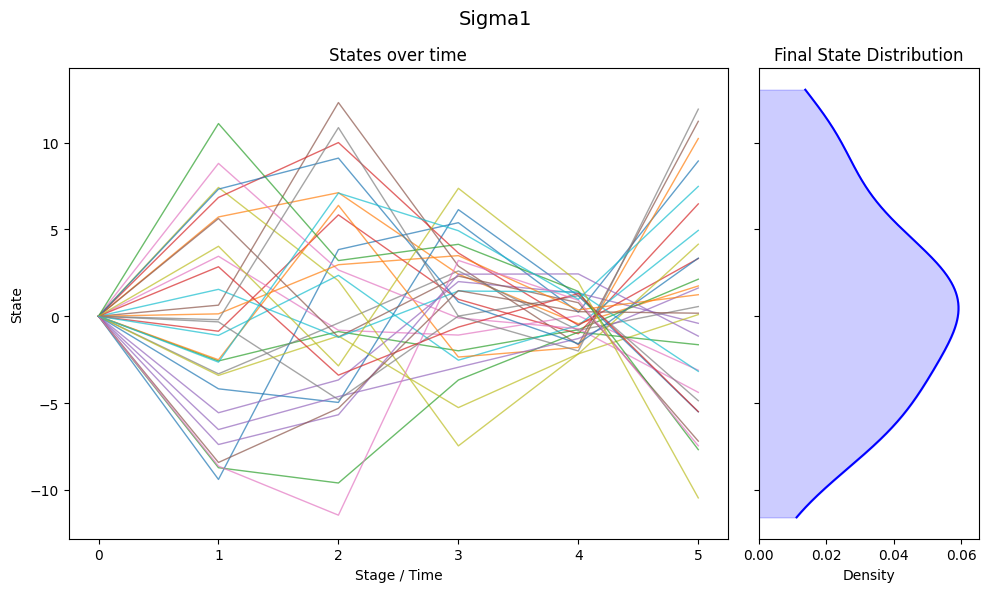

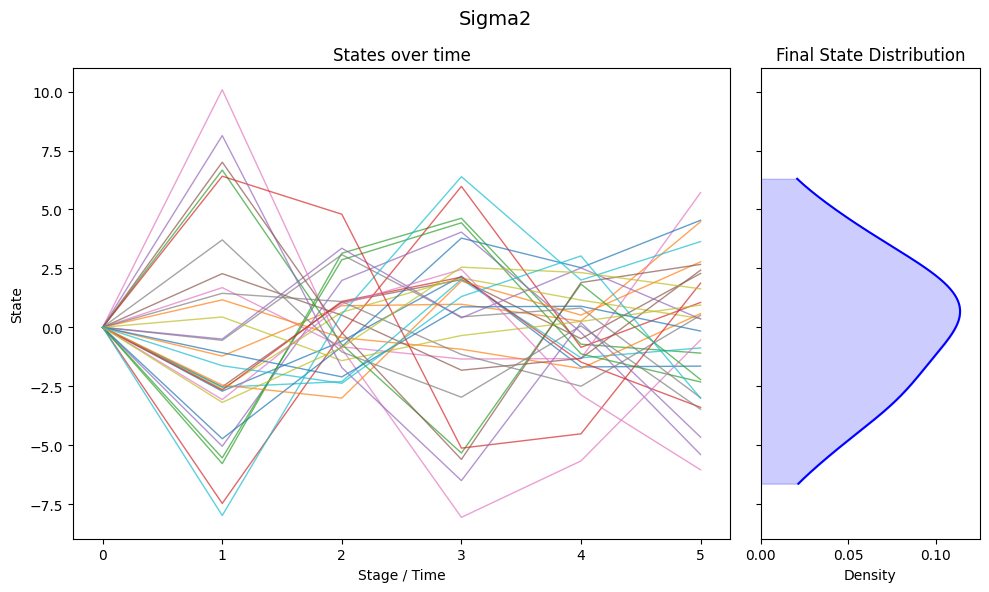

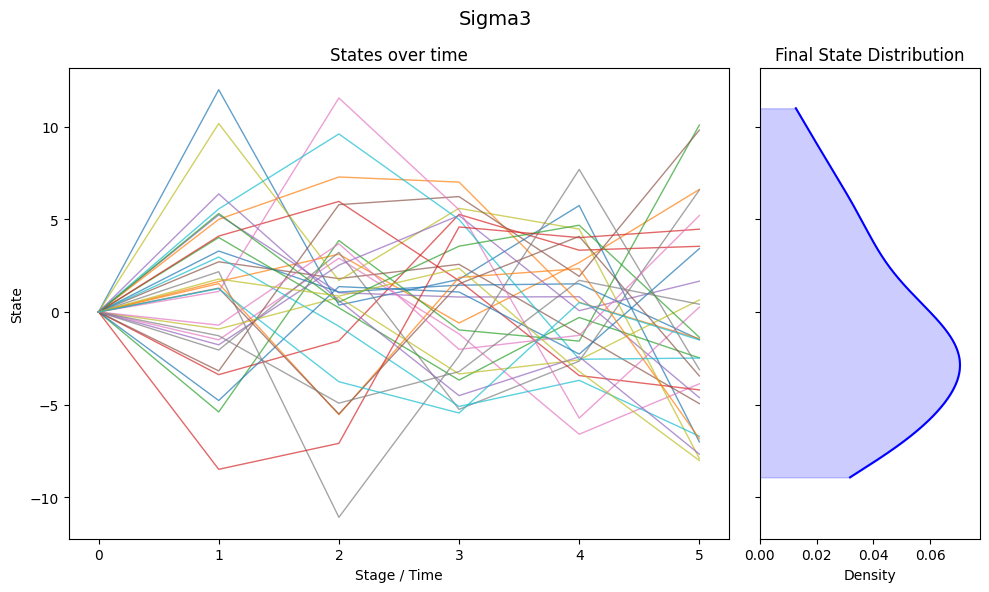

In [ ]:
tree1 = build_tree_from_paths(samples1_with_zero, weights)
tree2 = build_tree_from_paths(samples2_with_zero, weights)
tree3 = build_tree_from_paths(samples3_with_zero, weights)

visualize_big_tree(tree1, title= "Sigma1")
visualize_big_tree(tree2, title= "Sigma2")
visualize_big_tree(tree3, title= "Sigma3")

Training took 24.46 seconds.
Number of NaN losses encountered: 69
Trained estimator for k = 2. Number of NaN losses: 69
Training took 30.02 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 4. Number of NaN losses: 0
Training took 36.85 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 6. Number of NaN losses: 0
Training took 44.66 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 8. Number of NaN losses: 0
Training took 49.68 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 10. Number of NaN losses: 0


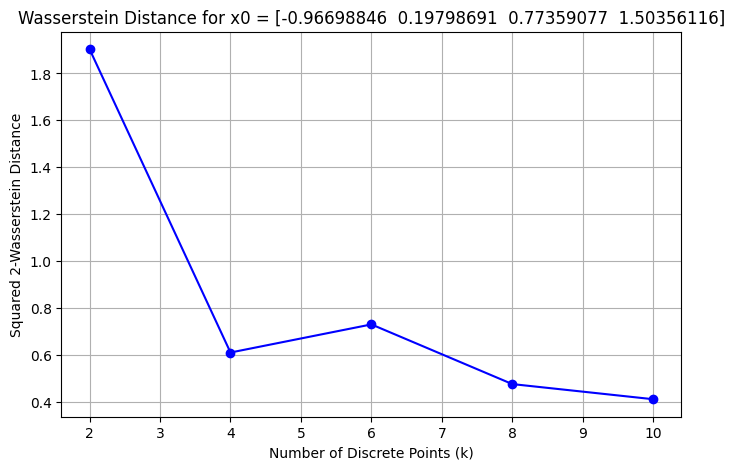

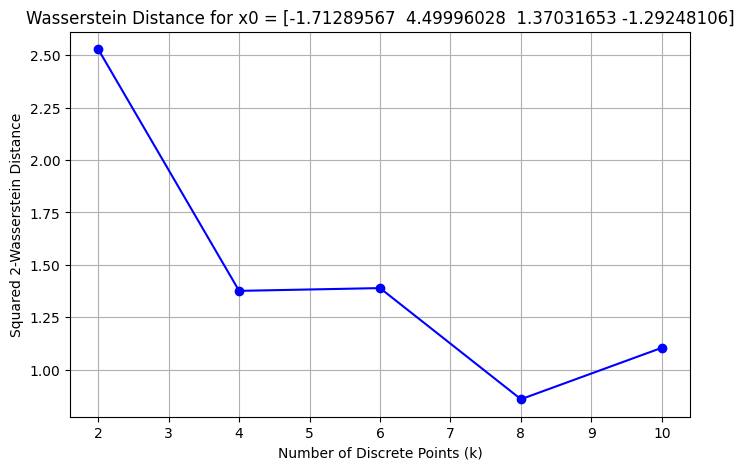

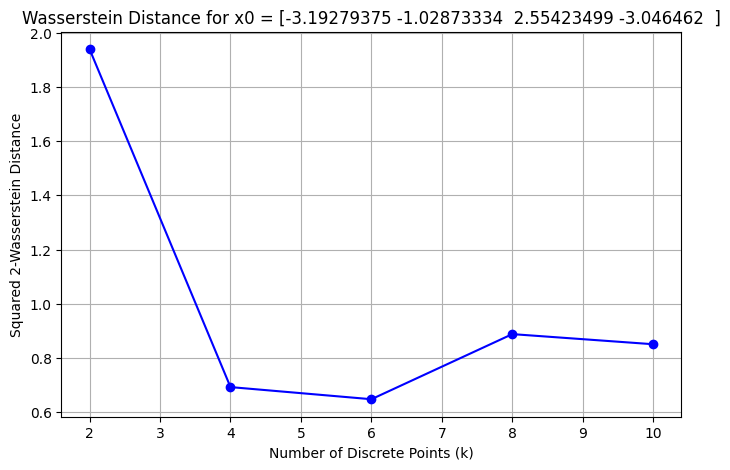

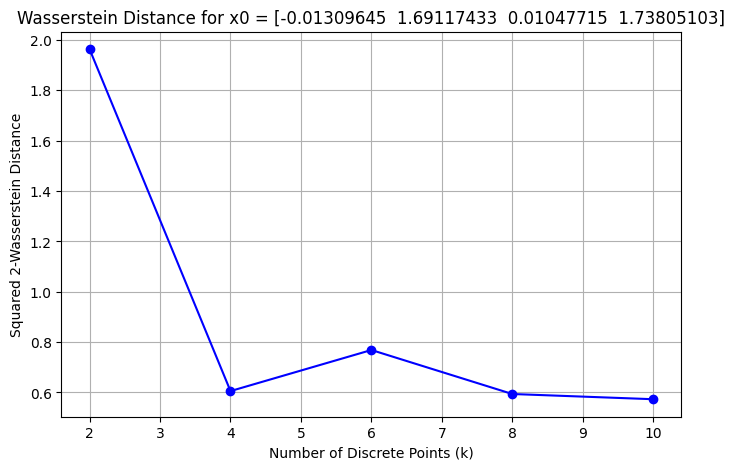

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
import ot  # for computing Wasserstein distance

def compute_true_conditional(z_obs, Sigma):
    """
    Given an observation z_obs = [x1, x2, x3, x4] and a 5x5 covariance matrix Sigma,
    compute the conditional distribution of x5 given z_obs.
    Returns:
      cond_mean: scalar, the conditional mean
      cond_var: scalar, the conditional variance
    """
    # In our full vector x = [x1, x2, x3, x4, x5],
    # let z correspond to indices 0,1,2,3 and y = x5 (index 4)
    indices_z = [0, 1, 2, 3]
    index_y = 4

    Sigma_zz = Sigma[np.ix_(indices_z, indices_z)]
    Sigma_yz = Sigma[index_y, indices_z].reshape(1, -1)  # shape (1,4)
    Sigma_yy = Sigma[index_y, index_y]  # scalar

    Sigma_zz_inv = np.linalg.inv(Sigma_zz)
    cond_mean = (Sigma_yz @ Sigma_zz_inv @ z_obs.reshape(-1, 1)).item()
    cond_var = Sigma_yy - (Sigma_yz @ Sigma_zz_inv @ Sigma_yz.T).item()
    return cond_mean, cond_var


def compute_w2_squared(discrete_support, discrete_weights, true_support, true_weights):
    """
    Compute squared 2-Wasserstein distance between two discrete measures.
    discrete_support: 1D numpy array of support points (length m)
    discrete_weights: 1D numpy array of weights (length m, summing to 1)
    true_support: 1D numpy array of support points for the true measure (length n)
    true_weights: 1D numpy array of weights for the true measure (length n, summing to 1)
    """
    # Compute the squared Euclidean cost matrix between the supports.
    M = (discrete_support[:, None] - true_support[None, :])**2
    # ot.emd2 returns the squared Wasserstein distance
    return ot.emd2(discrete_weights, true_weights, M)

# Mean is zero for a 5-dimensional Gaussian
mean = np.zeros(5)

num_paths = 3000
# Draw 3000 samples (each is a 5-dimensional vector) and prepend a deterministic 0,
# so that each sample path is of length 6: [0, x1, x2, x3, x4, x5]
samplesA = np.random.multivariate_normal(mean, sigma2_pd, size=num_paths)
samplesA_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesA])

# --- Prepare Data for Training the Conditional Density Estimator ---
# We use entries 1 to 4 (indices 1:5) as input (X) and entry 5 (index 5) as output (Y).
t = 4
X = samplesA_with_zero[:, 1:t+1]   # shape (num_paths, 4)
Y = samplesA_with_zero[:, t+1]       # shape (num_paths,)

# Optionally, combine X and Y into a single data array if needed.
data = np.concatenate([X, Y.reshape(-1, 1)], axis=1)

# Convert to torch tensor.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

# --- Training and Evaluation ---
# (Assume you have defined your function train_conditional_density which returns an estimator
# with an attribute 'atomnet' that, given an input x0 (a 4-dimensional vector), outputs k discrete points.)
#
# For evaluation we define a list of conditioning inputs (x0_values), where each x0 is a 4-dim vector.
x0_values = [X[0], X[50], X[1000], X[1500]]
results = {tuple(x0): {} for x0 in x0_values}  # keys as tuples for immutability

k_values = list(range(2, 11, 2))  # e.g. 2, 4, 6, 8, 10

# --- Main Loop over k ---
for k in k_values:
    # Train the conditional density estimator for current k.
    # (train_conditional_density should be defined in your code.)
    estimator, loss_hist, n_nan = train_conditional_density(
        data_tensor, d_X=4, d_Y=1, k=k,
        n_iter=1500, n_batch=100, lr=1e-3, nns_type=' '  # adjust as needed
    )
    
    estimator.atomnet.to(device)
    estimator.atomnet.eval()
    print(f"Trained estimator for k = {k}. Number of NaN losses: {n_nan}")
    
    for x0 in x0_values:
        # x0 is a 4-dimensional numpy array (conditioning input)
        with torch.no_grad():
            # Make sure x0 is of shape [1,4]
            x0_tensor = torch.tensor(x0.reshape(1, -1), dtype=torch.float32, device=device)
            # The estimator outputs k points (discrete support) for the conditional distribution of x5.
            y_est = estimator.atomnet(x0_tensor)  # assumed shape [1, k]
        y_est_np = y_est.cpu().numpy().flatten()
        weights_est = np.ones(k) / k
        
        # Now compute the true conditional distribution parameters for x5 given x0.
        cond_mean, cond_var = compute_true_conditional(np.array(x0), sigma2_pd)
        cond_std = np.sqrt(cond_var)
        
        # Create a grid for the true measure. For example, use a window of ±5 around cond_mean.
        y_min = cond_mean - 5
        y_max = cond_mean + 5
        y_grid = np.linspace(y_min, y_max, 800)
        dx = y_grid[1] - y_grid[0]
        
        true_pdf = norm.pdf(y_grid, loc=cond_mean, scale=cond_std)
        true_weights = true_pdf * dx
        true_weights = true_weights / np.sum(true_weights)
        
        # Compute squared 2-Wasserstein distance between the discrete and true measures.
        distance = compute_w2_squared(y_est_np, weights_est, y_grid, true_weights)
        results[tuple(x0)][k] = distance

# --- Plotting: one plot per conditioning input ---
for x0 in x0_values:
    ks = sorted(results[tuple(x0)].keys())
    distances = [results[tuple(x0)][k] for k in ks]
    plt.figure(figsize=(8, 5))
    plt.plot(ks, distances, marker='o', linestyle='-', color='blue')
    plt.xlabel('Number of Discrete Points (k)')
    plt.ylabel('Squared 2-Wasserstein Distance')
    plt.title(f'Wasserstein Distance for x0 = {x0}')
    plt.grid(True)
    plt.show()

Training took 23.90 seconds.
Number of NaN losses encountered: 100
Trained estimator for k = 2. Number of NaN losses: 100
Training took 31.59 seconds.
Number of NaN losses encountered: 1
Trained estimator for k = 4. Number of NaN losses: 1
Training took 34.08 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 6. Number of NaN losses: 0
Training took 40.42 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 8. Number of NaN losses: 0
Training took 45.07 seconds.
Number of NaN losses encountered: 0
Trained estimator for k = 10. Number of NaN losses: 0


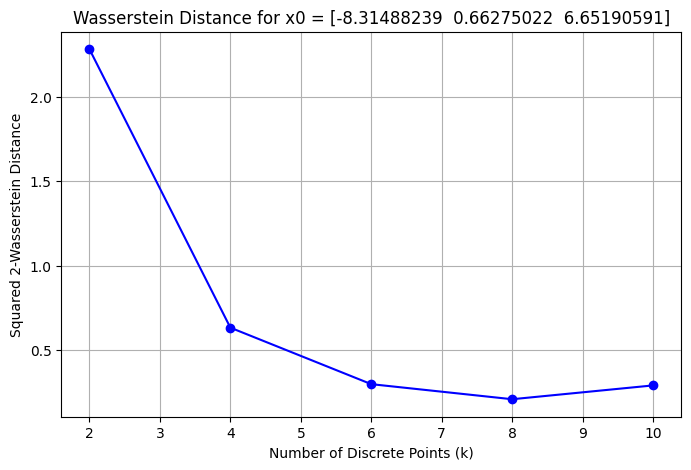

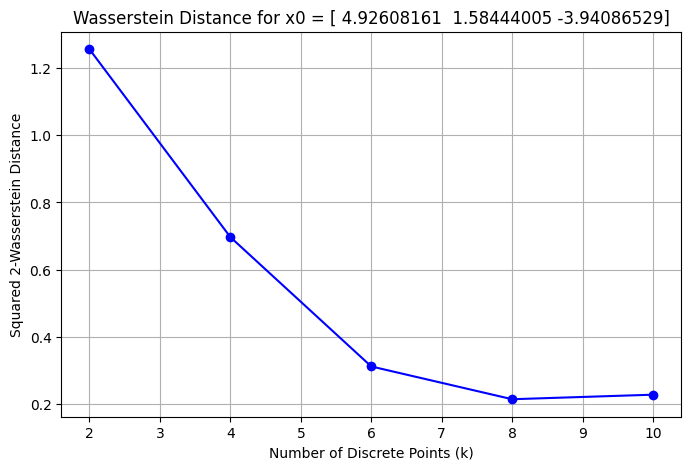

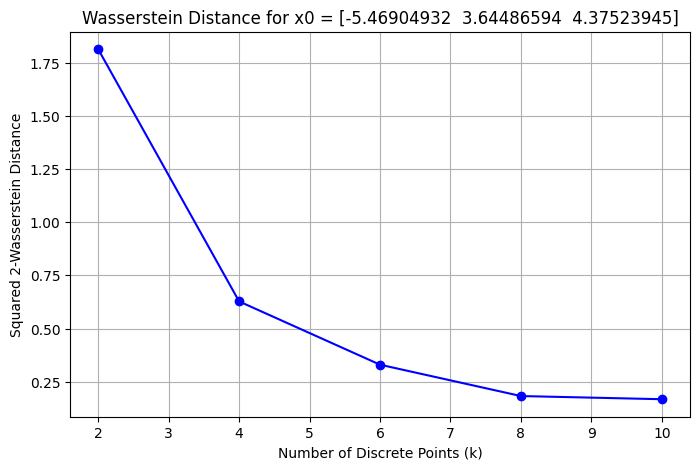

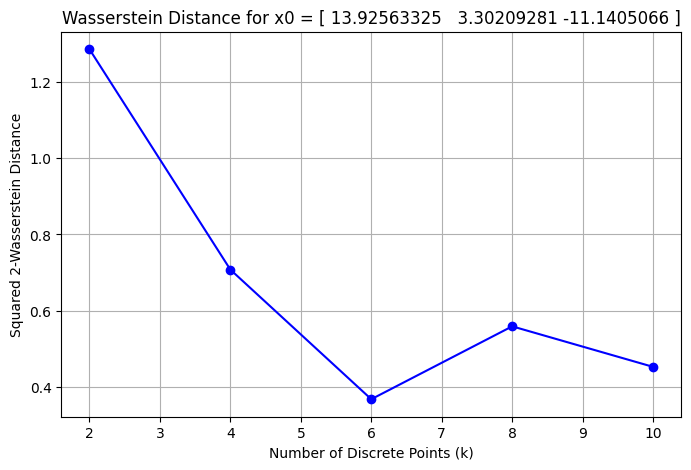

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
import ot  # for computing Wasserstein distance

# --- True Conditional Distribution Function for x4 given [x1,x2,x3] ---
def compute_true_conditional_x4(z_obs, Sigma):
    """
    Given an observation z_obs = [x1, x2, x3] and a 5x5 covariance matrix Sigma,
    compute the conditional distribution of x4 given z_obs.
    Returns:
      cond_mean: scalar, the conditional mean of x4
      cond_var: scalar, the conditional variance of x4
    """
    # For the full vector x = [x1, x2, x3, x4, x5],
    # let z correspond to indices 0,1,2 (i.e. x1, x2, x3) and y = x4 (index 3)
    indices_z = [0, 1, 2]
    index_y = 3

    Sigma_zz = Sigma[np.ix_(indices_z, indices_z)]
    Sigma_yz = Sigma[index_y, indices_z].reshape(1, -1)  # shape (1,3)
    Sigma_yy = Sigma[index_y, index_y]  # scalar

    Sigma_zz_inv = np.linalg.inv(Sigma_zz)
    cond_mean = (Sigma_yz @ Sigma_zz_inv @ z_obs.reshape(-1, 1)).item()
    cond_var = Sigma_yy - (Sigma_yz @ Sigma_zz_inv @ Sigma_yz.T).item()
    return cond_mean, cond_var

mean = np.zeros(5)

num_paths = 3000
# Draw 3000 samples (each is a 5-dimensional vector) and prepend a deterministic 0,
# so that each sample path is of length 6: [0, x1, x2, x3, x4, x5]
samplesA = np.random.multivariate_normal(mean, sigma2_pd, size=num_paths)
samplesA_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesA])

# --- Prepare Data for Training the Conditional Density Estimator ---
# Now we use entries 1 to 3 (indices 1:4) as input (X) and entry 4 (index 4) as output (Y).
t = 3
X = samplesA_with_zero[:, 1:t+1]   # shape: (num_paths, 3) for x1, x2, x3
Y = samplesA_with_zero[:, t+1]       # shape: (num_paths,) for x4

# Optionally, combine X and Y into a single data array.
data = np.concatenate([X, Y.reshape(-1, 1)], axis=1)

# Convert to torch tensor.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

# --- Training and Evaluation ---
# (Assume you have a function train_conditional_density that returns an estimator
# with an attribute 'atomnet' that, given an input x0 (a 3-dimensional vector), outputs k discrete points.)

# Define some conditioning inputs (x0_values), each a 3-dim vector.
x0_values = [X[0], X[50], X[1000], X[1500]]
results = {tuple(x0): {} for x0 in x0_values}  # keys as tuples for immutability

k_values = list(range(2, 11, 2))  # e.g. k = 2, 4, 6, 8, 10

# --- Main Loop over k ---
for k in k_values:
    # Train the conditional density estimator for the current k.
    # (train_conditional_density should be defined in your code.)
    estimator, loss_hist, n_nan = train_conditional_density(
        data_tensor, d_X=3, d_Y=1, k=k,
        n_iter=1500, n_batch=100, lr=1e-3, nns_type=' '  # adjust parameters as needed
    )
    
    estimator.atomnet.to(device)
    estimator.atomnet.eval()
    print(f"Trained estimator for k = {k}. Number of NaN losses: {n_nan}")
    
    for x0 in x0_values:
        # x0 is a 3-dimensional numpy array (conditioning input)
        with torch.no_grad():
            # Ensure x0 is of shape [1,3]
            x0_tensor = torch.tensor(x0.reshape(1, -1), dtype=torch.float32, device=device)
            # The estimator outputs k points (discrete support) for the conditional distribution of x4.
            y_est = estimator.atomnet(x0_tensor)  # assumed shape [1, k]
        y_est_np = y_est.cpu().numpy().flatten()
        weights_est = np.ones(k) / k
        
        # Compute the true conditional distribution parameters for x4 given x0.
        cond_mean, cond_var = compute_true_conditional_x4(np.array(x0), sigma2_pd)
        cond_std = np.sqrt(cond_var)
        
        # Create a grid for the true measure. For instance, a window of ±5 around cond_mean.
        y_min = cond_mean - 5
        y_max = cond_mean + 5
        y_grid = np.linspace(y_min, y_max, 800)
        dx = y_grid[1] - y_grid[0]
        
        true_pdf = norm.pdf(y_grid, loc=cond_mean, scale=cond_std)
        true_weights = true_pdf * dx
        true_weights = true_weights / np.sum(true_weights)
        
        # Compute squared 2-Wasserstein distance between the discrete and true measures.
        distance = compute_w2_squared(y_est_np, weights_est, y_grid, true_weights)
        results[tuple(x0)][k] = distance

# --- Plotting: one plot per conditioning input ---
for x0 in x0_values:
    ks = sorted(results[tuple(x0)].keys())
    distances = [results[tuple(x0)][k] for k in ks]
    plt.figure(figsize=(8, 5))
    plt.plot(ks, distances, marker='o', linestyle='-', color='blue')
    plt.xlabel('Number of Discrete Points (k)')
    plt.ylabel('Squared 2-Wasserstein Distance')
    plt.title(f'Wasserstein Distance for x0 = {x0}')
    plt.grid(True)
    plt.show()


## FVI between Sigma 2 and classic BW (DOES NOT WORK WELL)

-----------------------------------------------
Run: 0.0000
Time step 5 Loss: 0.11404828760772943
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.65 seconds.
Number of NaN losses encountered: 0


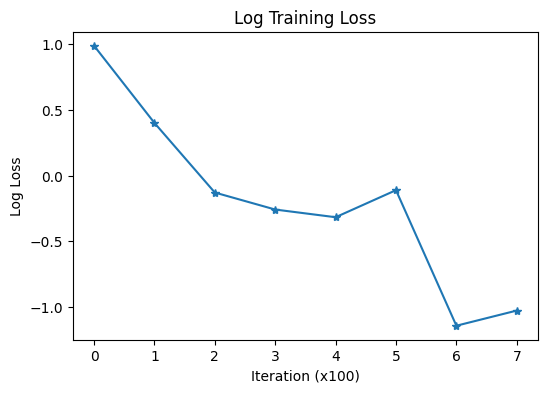

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.20 seconds.
Number of NaN losses encountered: 0


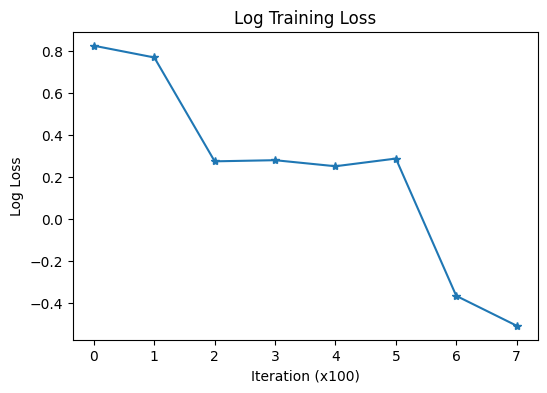

Time step 4 Loss: 3.9803892087936403
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.95 seconds.
Number of NaN losses encountered: 0


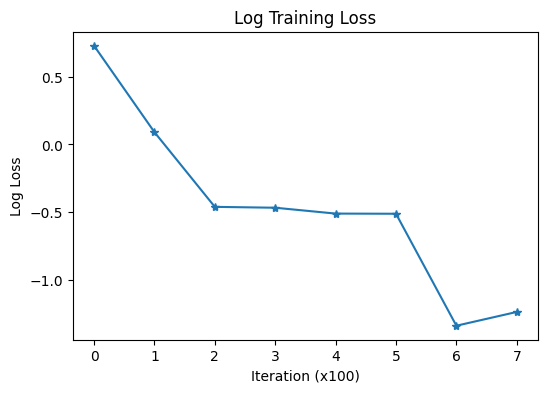

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.46 seconds.
Number of NaN losses encountered: 0


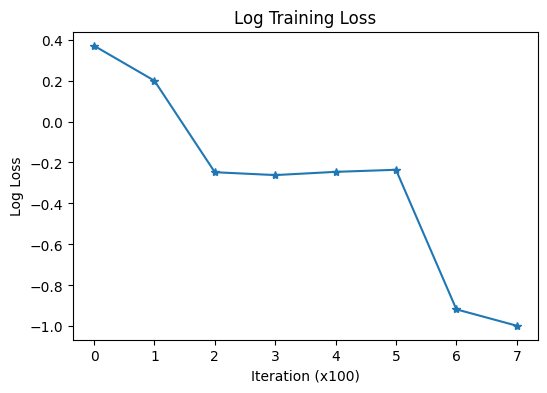

Time step 3 Loss: 2.164229911565781
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.34 seconds.
Number of NaN losses encountered: 0


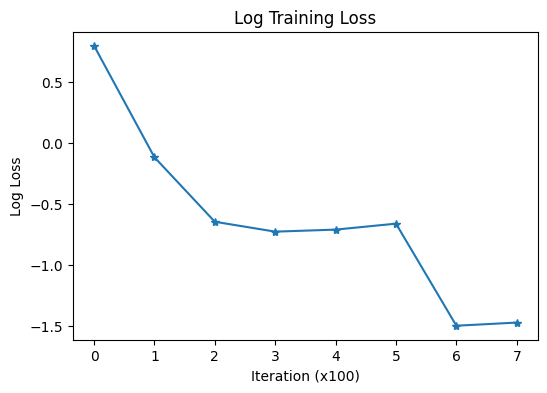

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.51 seconds.
Number of NaN losses encountered: 0


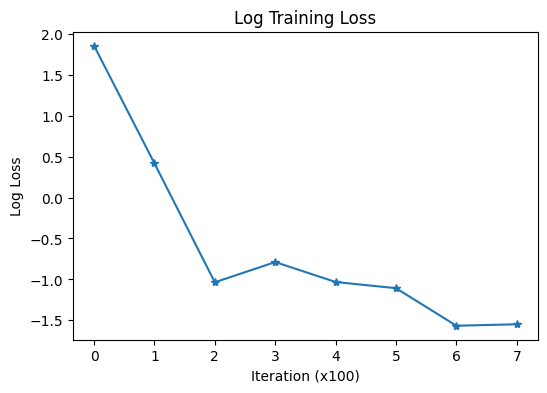

Time step 2 Loss: 13.816641101837158
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.65 seconds.
Number of NaN losses encountered: 0


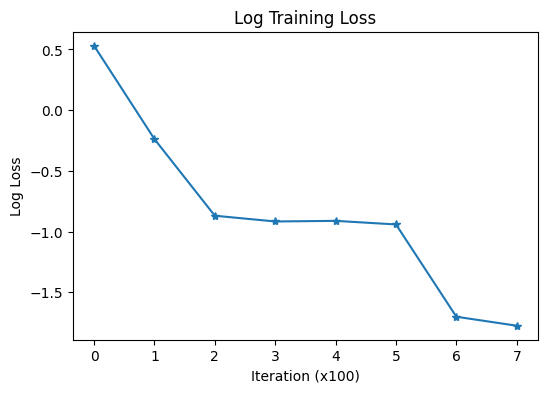

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.30 seconds.
Number of NaN losses encountered: 0


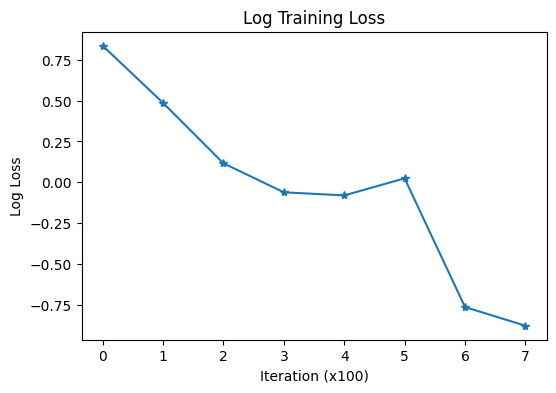

Time step 1 Loss: 1.1371064639091493
Time step 0 Loss: 7.934650201797485
Final value at time 0: 33.38433074951172
-----------------------------------------------
Run: 1.0000
Time step 5 Loss: 0.10704972464591264
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 16.41 seconds.
Number of NaN losses encountered: 0


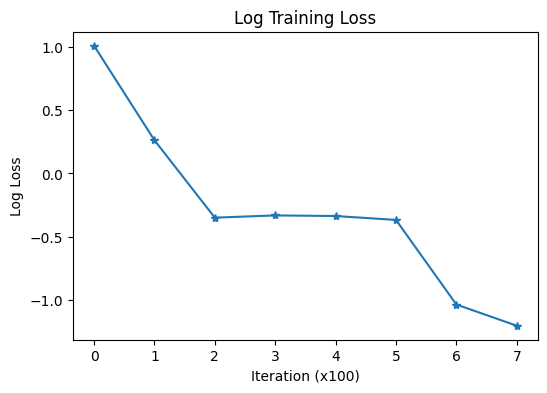

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 16.04 seconds.
Number of NaN losses encountered: 0


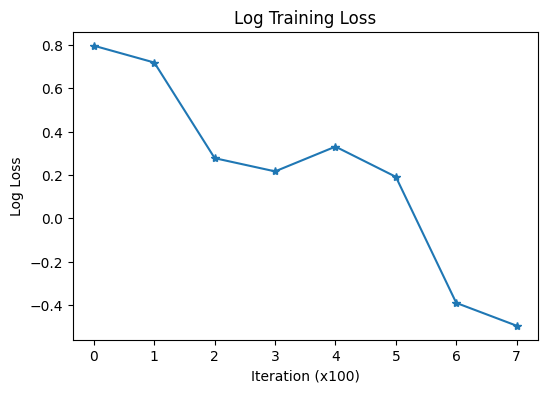

Time step 4 Loss: 4.282411775588989
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 15.92 seconds.
Number of NaN losses encountered: 0


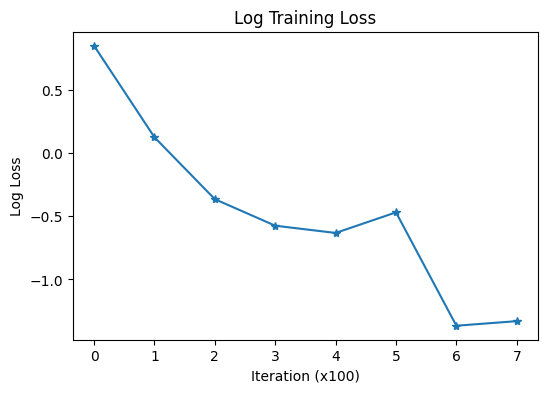

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 15.00 seconds.
Number of NaN losses encountered: 0


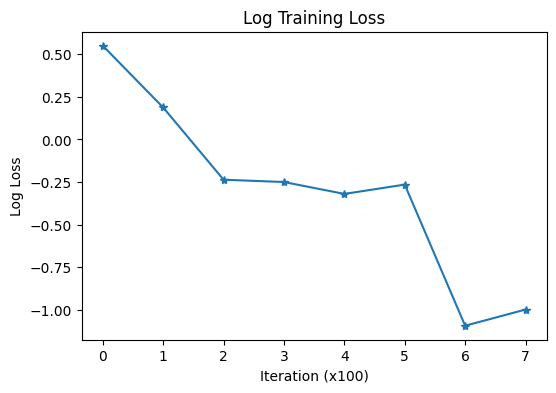

Time step 3 Loss: 2.6711182308197023
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.32 seconds.
Number of NaN losses encountered: 0


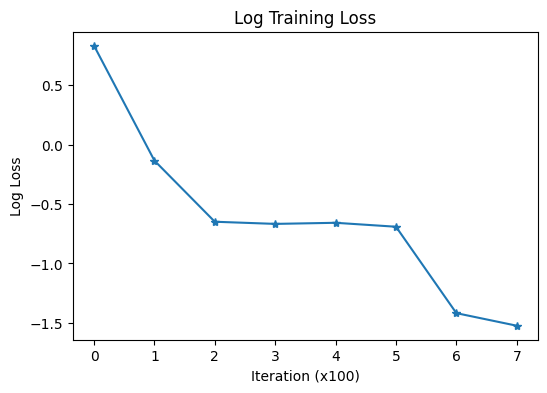

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.19 seconds.
Number of NaN losses encountered: 0


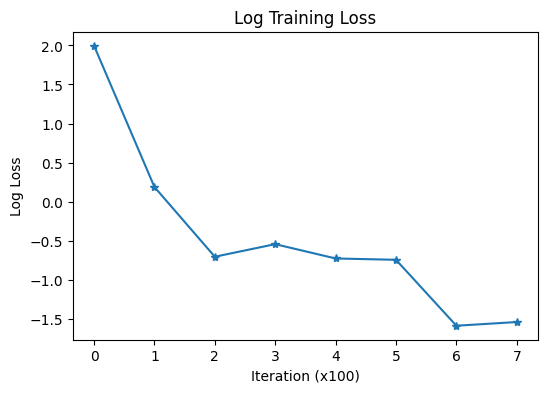

Time step 2 Loss: 14.983730278015138
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.27 seconds.
Number of NaN losses encountered: 0


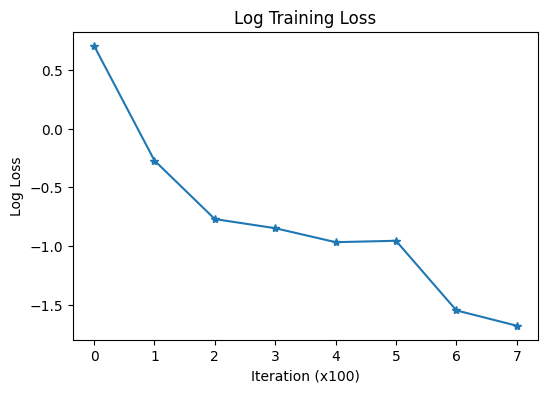

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.25 seconds.
Number of NaN losses encountered: 0


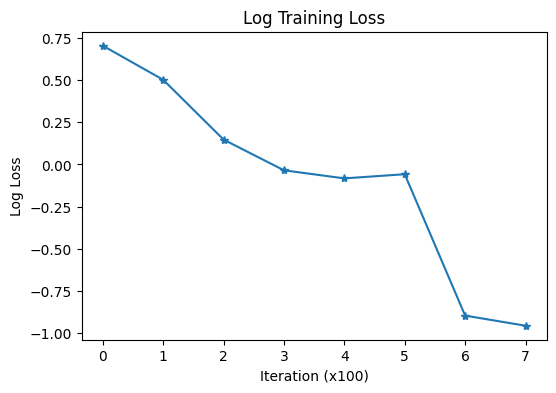

Time step 1 Loss: 2.5797977113723753
Time step 0 Loss: 8.048376035690307
Final value at time 0: 30.973012924194336
-----------------------------------------------
Run: 2.0000
Time step 5 Loss: 0.10822983846068382
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.59 seconds.
Number of NaN losses encountered: 0


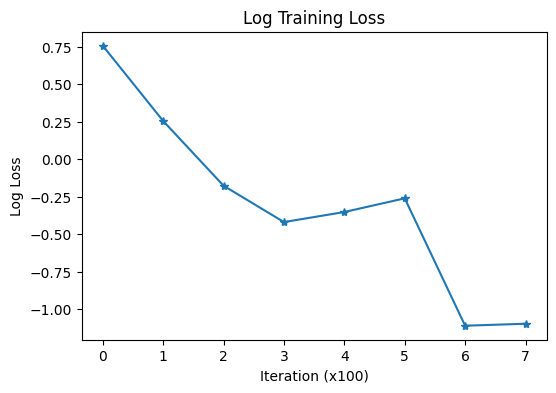

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.46 seconds.
Number of NaN losses encountered: 0


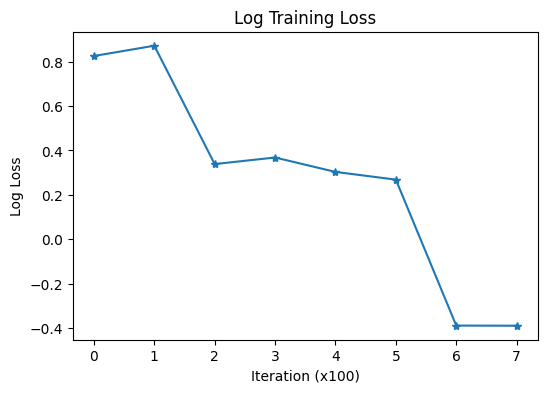

Time step 4 Loss: 3.85830668926239
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.92 seconds.
Number of NaN losses encountered: 0


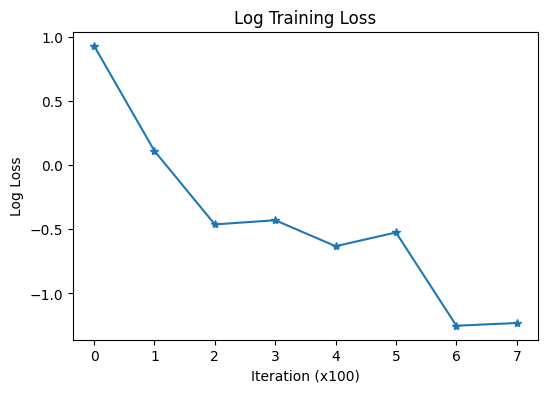

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.02 seconds.
Number of NaN losses encountered: 0


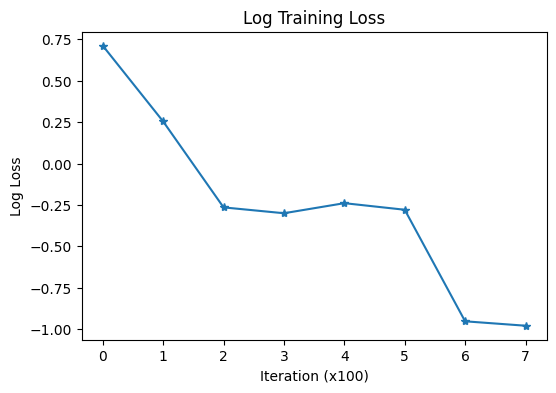

Time step 3 Loss: 2.1442935526371003
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.86 seconds.
Number of NaN losses encountered: 0


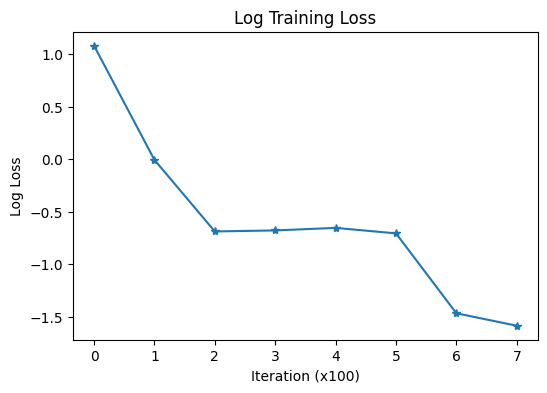

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.83 seconds.
Number of NaN losses encountered: 0


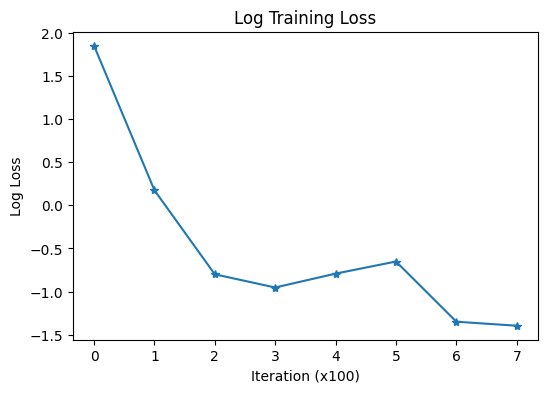

Time step 2 Loss: 15.1151607131958
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.52 seconds.
Number of NaN losses encountered: 0


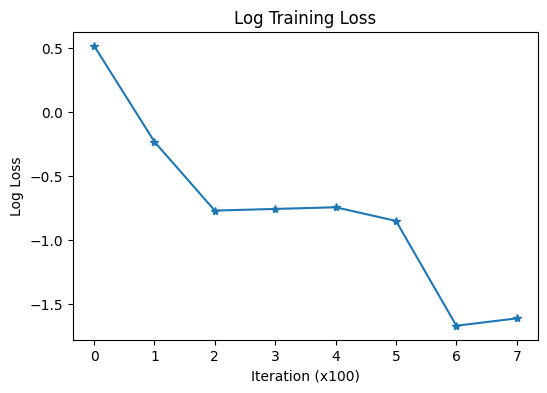

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.51 seconds.
Number of NaN losses encountered: 0


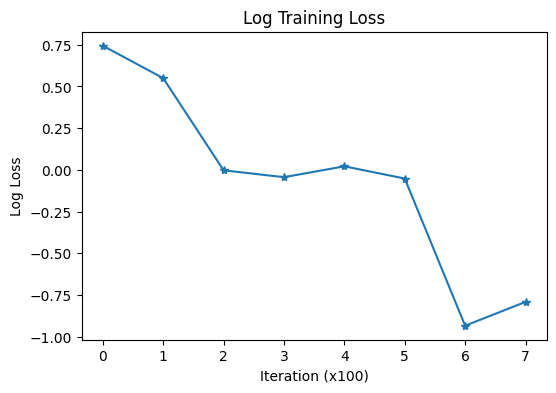

Time step 1 Loss: 1.1973939733207226
Time step 0 Loss: 7.771959676742553
Final value at time 0: 34.08122634887695
-----------------------------------------------
Run: 3.0000
Time step 5 Loss: 0.002073872732289601
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.82 seconds.
Number of NaN losses encountered: 0


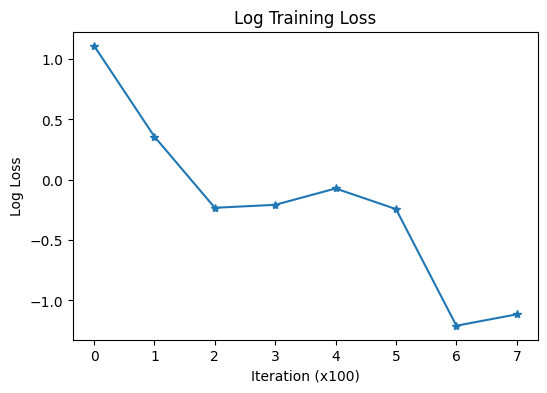

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.93 seconds.
Number of NaN losses encountered: 0


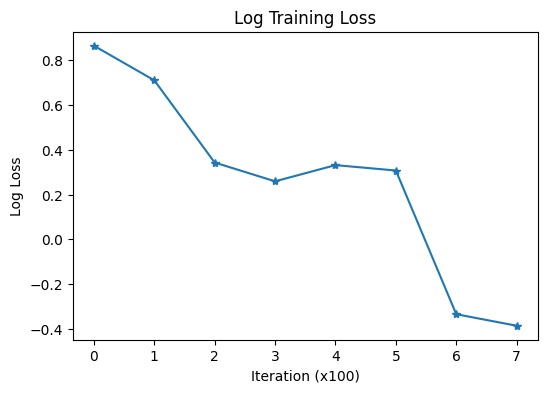

Time step 4 Loss: 3.971730103492737
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 21.70 seconds.
Number of NaN losses encountered: 0


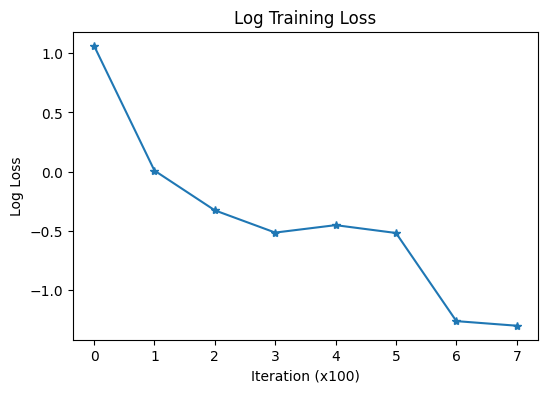

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 19.23 seconds.
Number of NaN losses encountered: 0


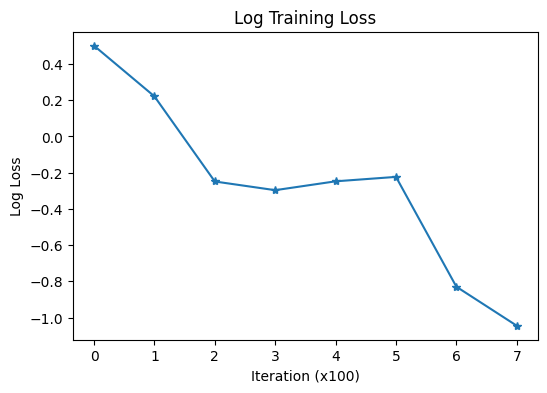

Time step 3 Loss: 2.400179862976074
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 16.06 seconds.
Number of NaN losses encountered: 0


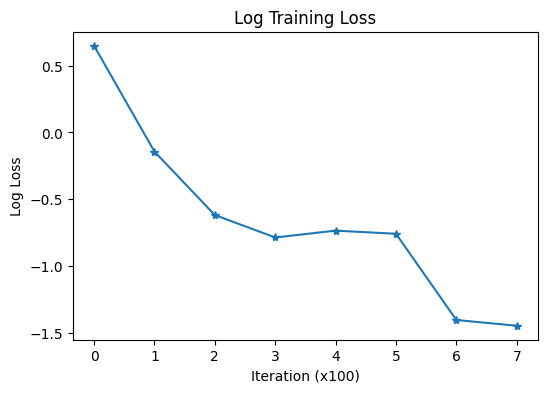

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 16.38 seconds.
Number of NaN losses encountered: 0


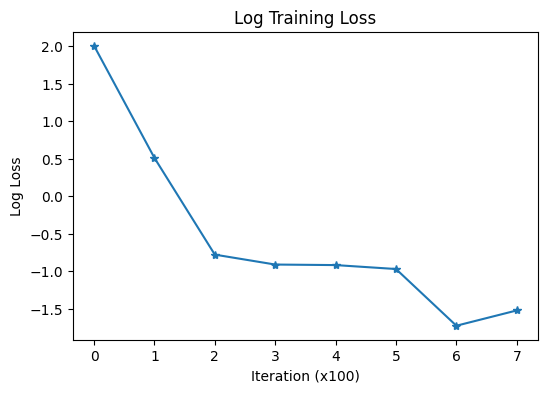

Time step 2 Loss: 15.085428028106689
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.73 seconds.
Number of NaN losses encountered: 0


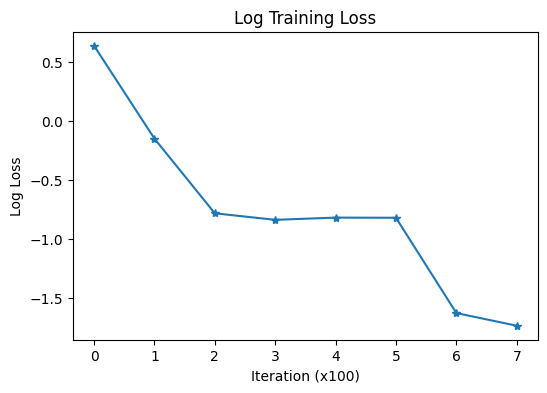

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.97 seconds.
Number of NaN losses encountered: 0


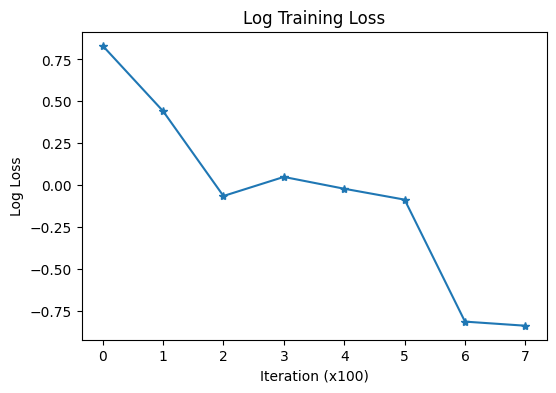

Time step 1 Loss: 1.2516104128956795
Time step 0 Loss: 8.423657398223877
Final value at time 0: 31.892906188964844
-----------------------------------------------
Run: 4.0000
Time step 5 Loss: 7.901472802586796e-05
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 16.07 seconds.
Number of NaN losses encountered: 0


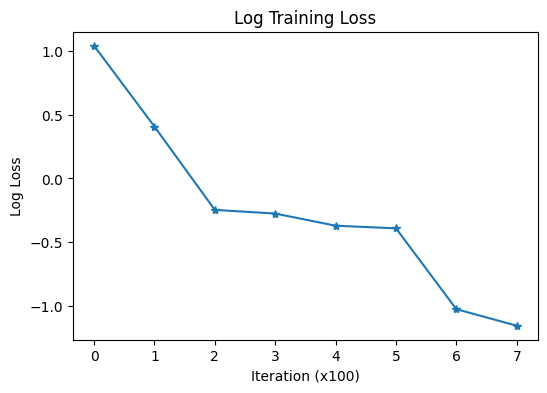

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 16.73 seconds.
Number of NaN losses encountered: 0


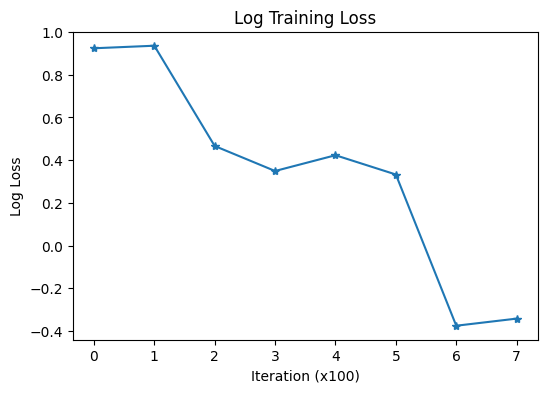

Time step 4 Loss: 4.749065852165222
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 16.56 seconds.
Number of NaN losses encountered: 0


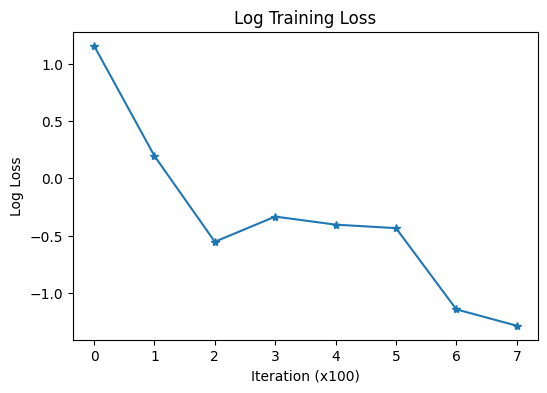

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 15.69 seconds.
Number of NaN losses encountered: 0


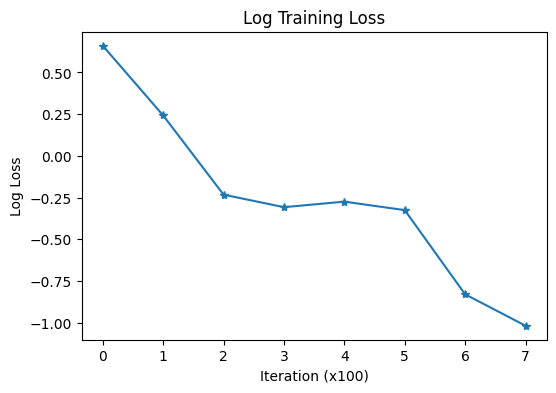

Time step 3 Loss: 2.6462299728393557
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.96 seconds.
Number of NaN losses encountered: 0


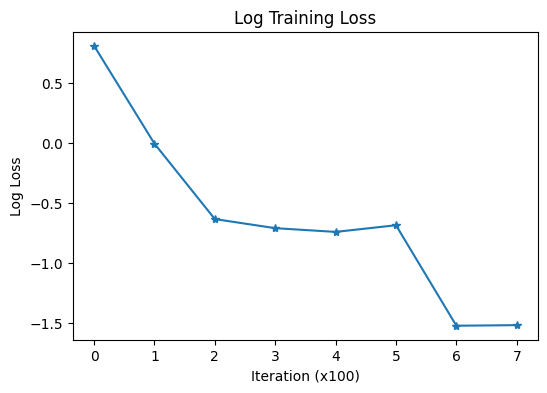

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 301.03 seconds.
Number of NaN losses encountered: 0


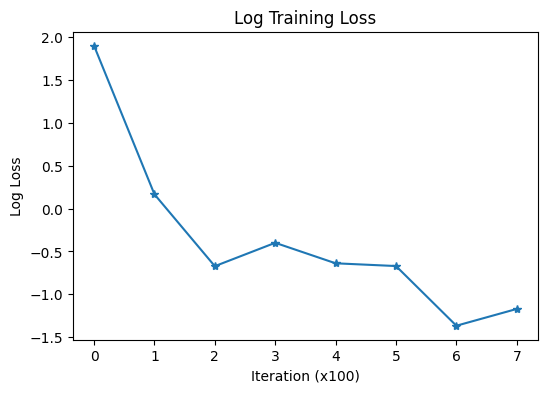

Time step 2 Loss: 13.781004676818847
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.53 seconds.
Number of NaN losses encountered: 0


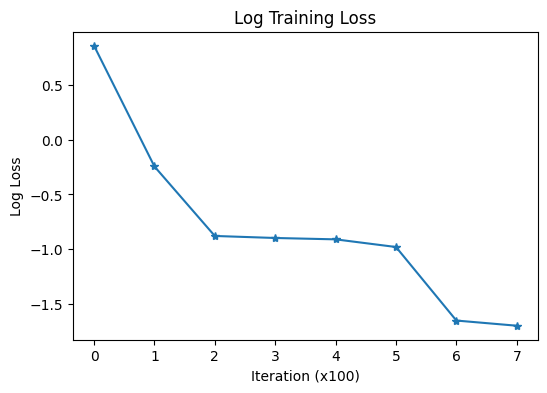

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.46 seconds.
Number of NaN losses encountered: 0


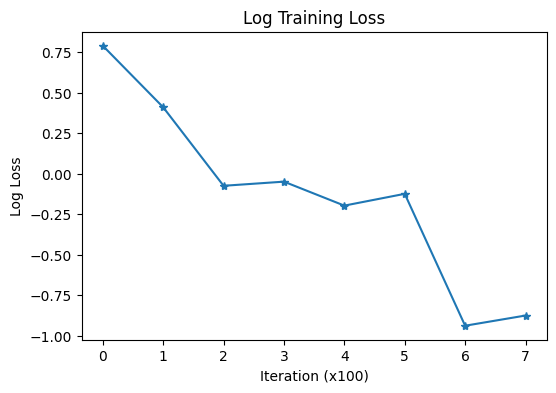

Time step 1 Loss: 1.5943829941749572
Time step 0 Loss: 7.834317255020141
Final value at time 0: 34.22085189819336
-----------------------------------------------
Run: 5.0000
Time step 5 Loss: 0.0036391983287285255
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.28 seconds.
Number of NaN losses encountered: 0


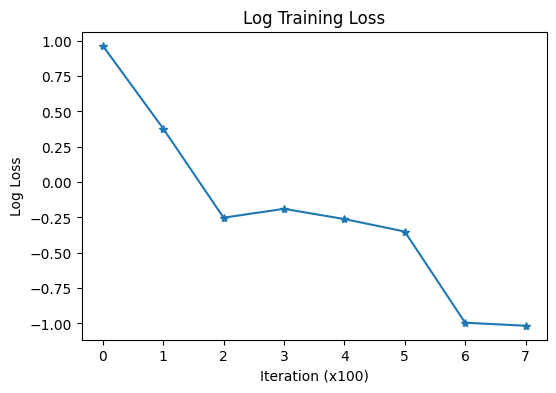

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.05 seconds.
Number of NaN losses encountered: 0


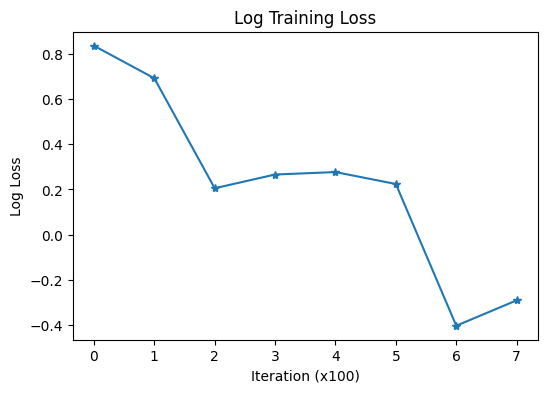

Time step 4 Loss: 3.258942790031433
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.44 seconds.
Number of NaN losses encountered: 0


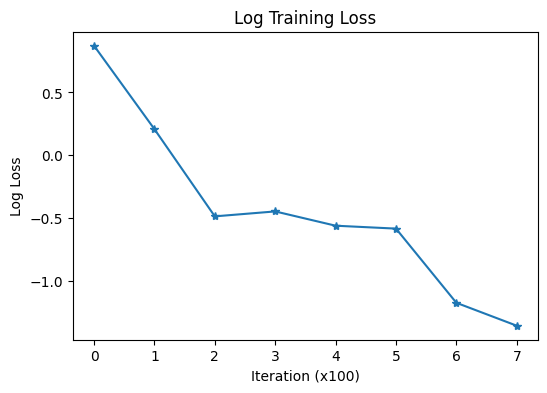

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.80 seconds.
Number of NaN losses encountered: 0


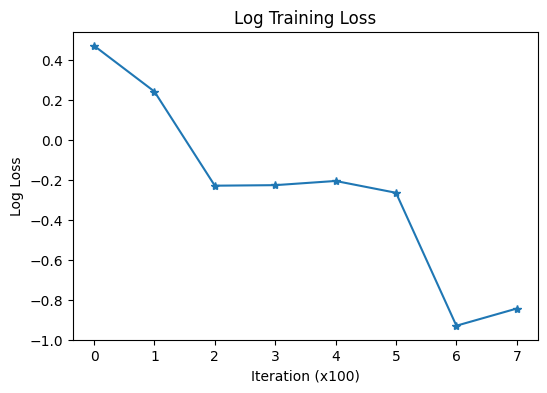

Time step 3 Loss: 1.815386414527893
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.73 seconds.
Number of NaN losses encountered: 0


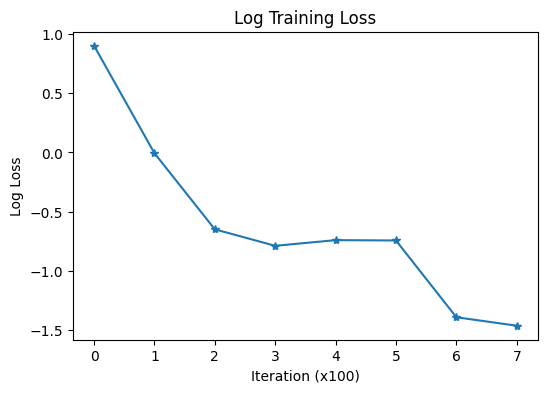

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.20 seconds.
Number of NaN losses encountered: 0


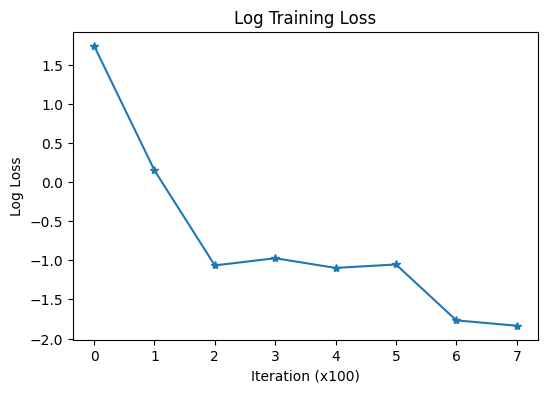

Time step 2 Loss: 14.532938594818114
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.01 seconds.
Number of NaN losses encountered: 0


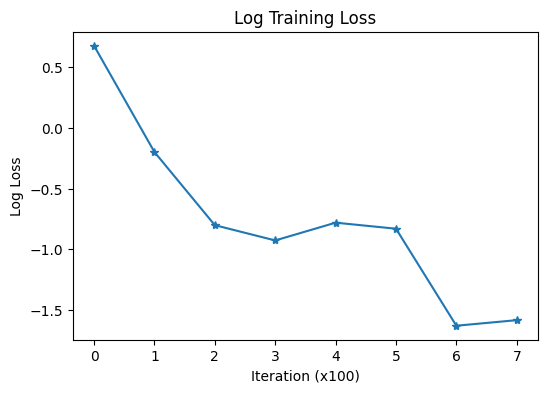

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.80 seconds.
Number of NaN losses encountered: 0


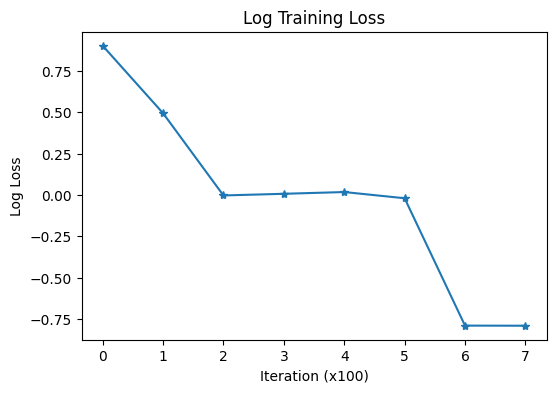

Time step 1 Loss: 1.1026200160384179
Time step 0 Loss: 8.10281252861023
Final value at time 0: 34.668975830078125
-----------------------------------------------
Run: 6.0000
Time step 5 Loss: 0.0016733765318713268
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.29 seconds.
Number of NaN losses encountered: 0


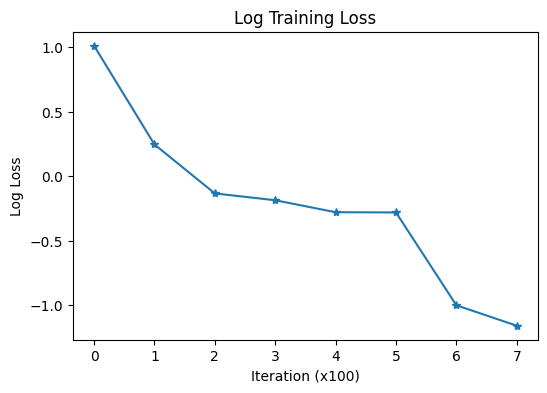

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.33 seconds.
Number of NaN losses encountered: 0


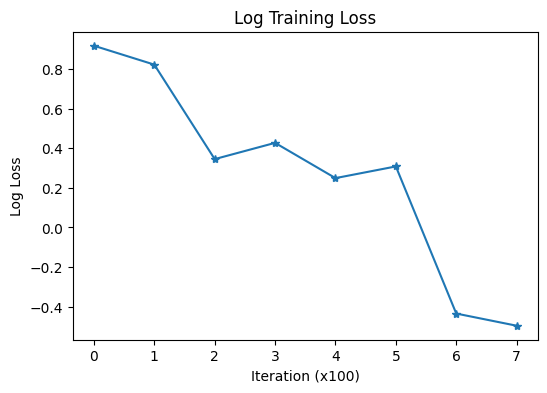

Time step 4 Loss: 2.984102282524109
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.12 seconds.
Number of NaN losses encountered: 0


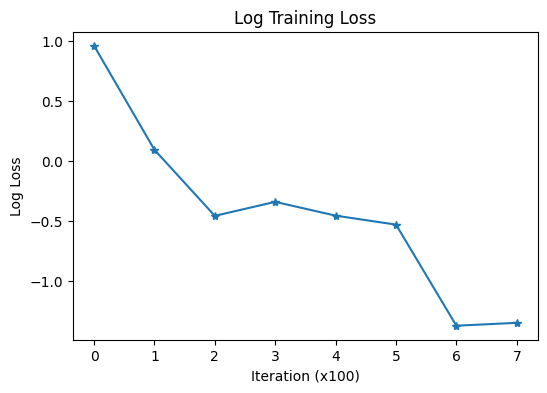

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.14 seconds.
Number of NaN losses encountered: 0


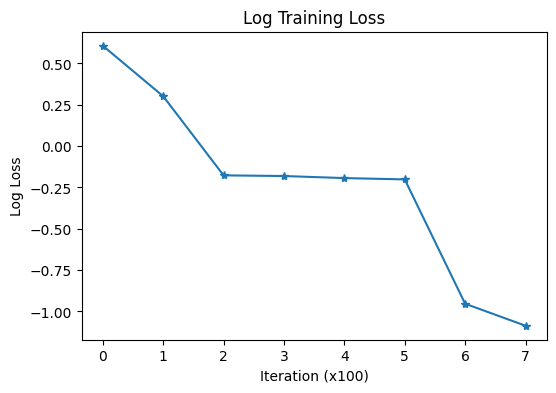

Time step 3 Loss: 2.073583445549011
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.91 seconds.
Number of NaN losses encountered: 0


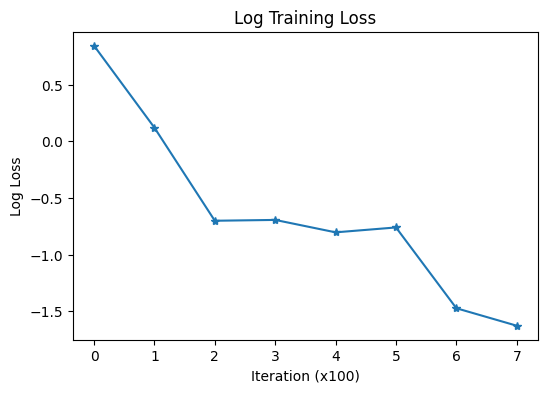

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.63 seconds.
Number of NaN losses encountered: 0


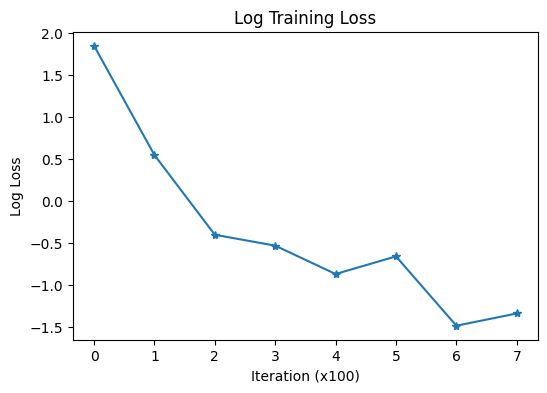

Time step 2 Loss: 14.021118564605713
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.20 seconds.
Number of NaN losses encountered: 0


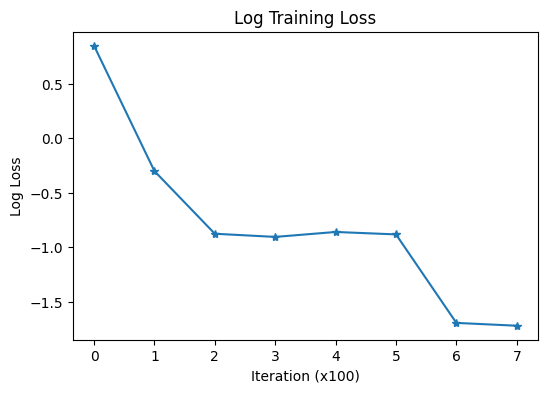

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.69 seconds.
Number of NaN losses encountered: 0


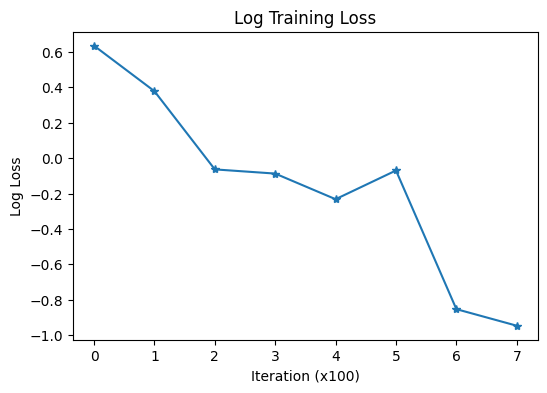

Time step 1 Loss: 1.3875042441487313
Time step 0 Loss: 7.966822471618652
Final value at time 0: 35.72190856933594
-----------------------------------------------
Run: 7.0000
Time step 5 Loss: 0.02100326290299563
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.52 seconds.
Number of NaN losses encountered: 0


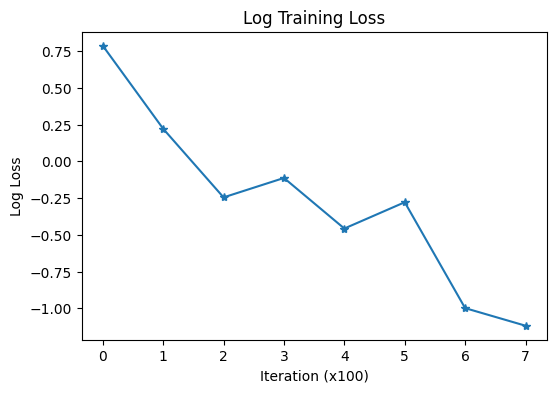

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 15.07 seconds.
Number of NaN losses encountered: 0


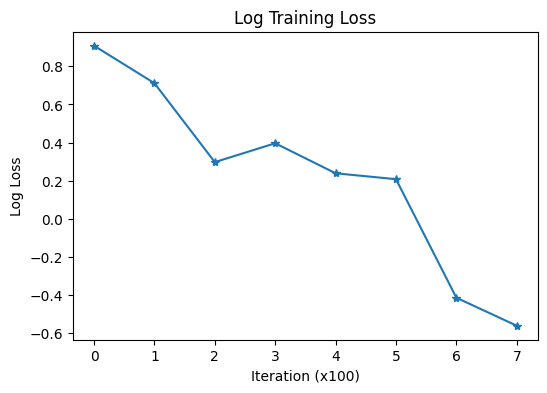

Time step 4 Loss: 4.1459376239776615
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.83 seconds.
Number of NaN losses encountered: 0


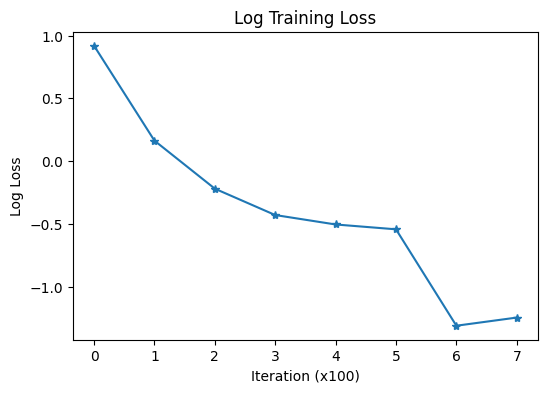

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.09 seconds.
Number of NaN losses encountered: 0


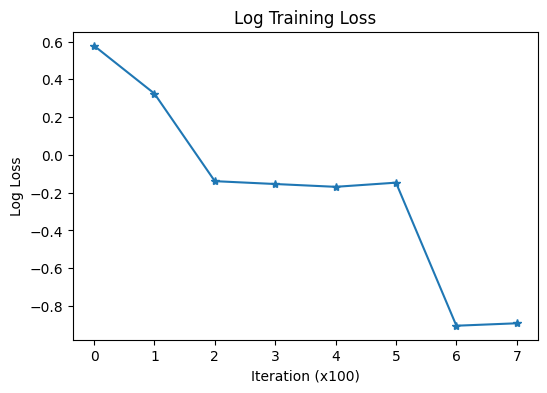

Time step 3 Loss: 1.8843046891689301
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.29 seconds.
Number of NaN losses encountered: 0


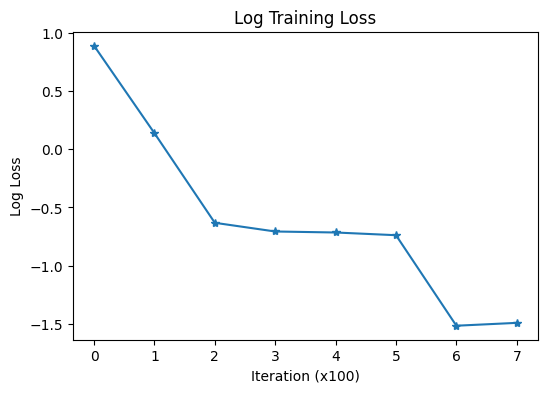

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.97 seconds.
Number of NaN losses encountered: 0


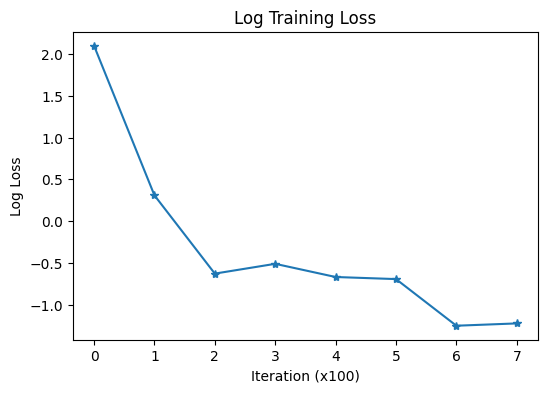

Time step 2 Loss: 14.989200859069824
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 10.35 seconds.
Number of NaN losses encountered: 0


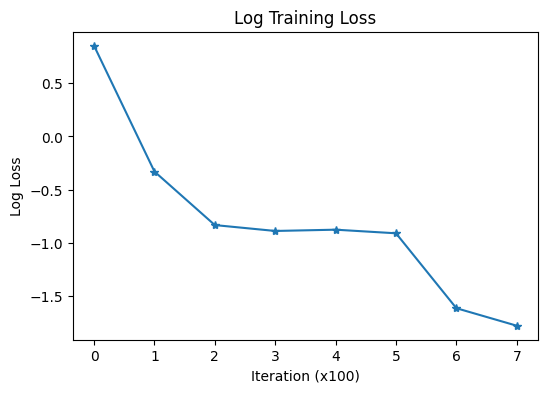

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.12 seconds.
Number of NaN losses encountered: 0


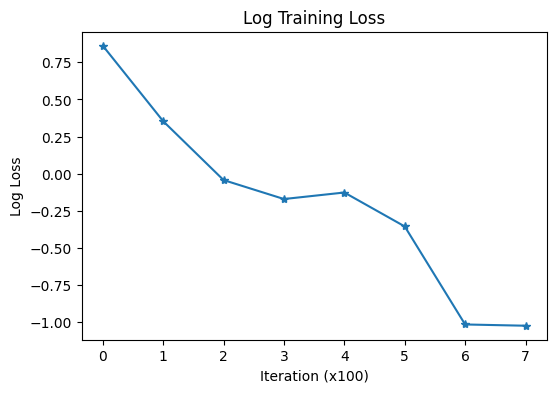

Time step 1 Loss: 1.117370336651802
Time step 0 Loss: 7.724050359725952
Final value at time 0: 36.41652297973633
-----------------------------------------------
Run: 8.0000
Time step 5 Loss: 0.008650087284804613
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 15.23 seconds.
Number of NaN losses encountered: 0


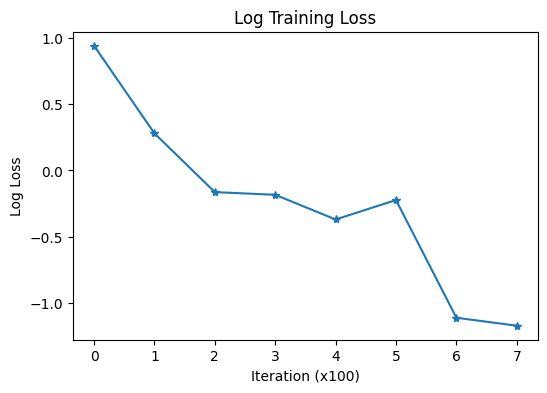

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.63 seconds.
Number of NaN losses encountered: 0


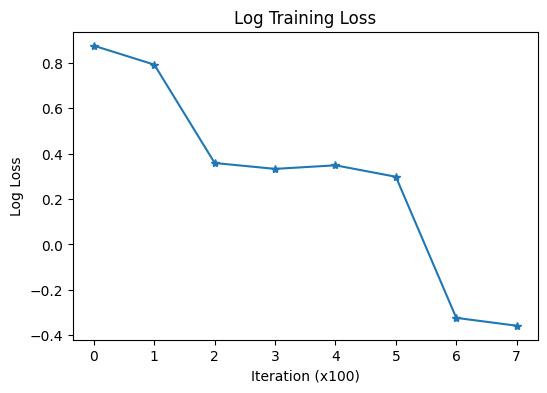

Time step 4 Loss: 3.1345186328887937
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.77 seconds.
Number of NaN losses encountered: 0


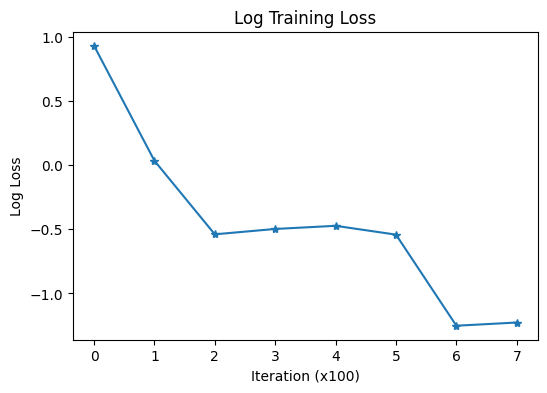

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 14.02 seconds.
Number of NaN losses encountered: 0


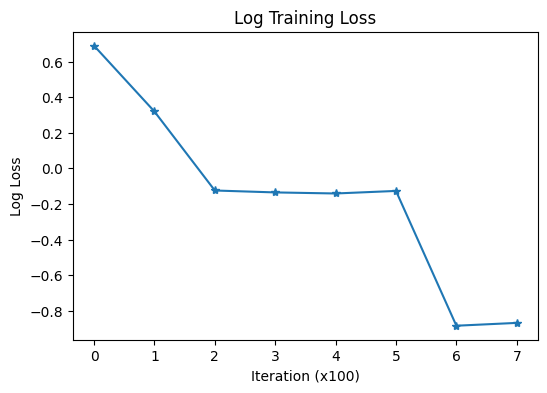

Time step 3 Loss: 2.5144045686721803
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.77 seconds.
Number of NaN losses encountered: 0


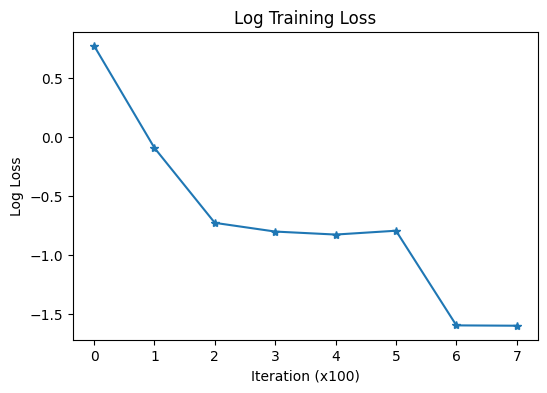

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.84 seconds.
Number of NaN losses encountered: 0


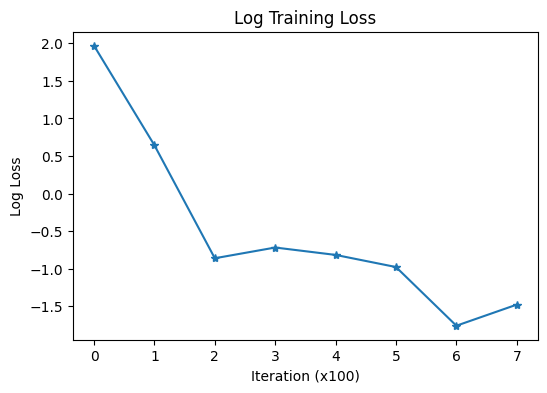

Time step 2 Loss: 14.83321891784668
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.22 seconds.
Number of NaN losses encountered: 0


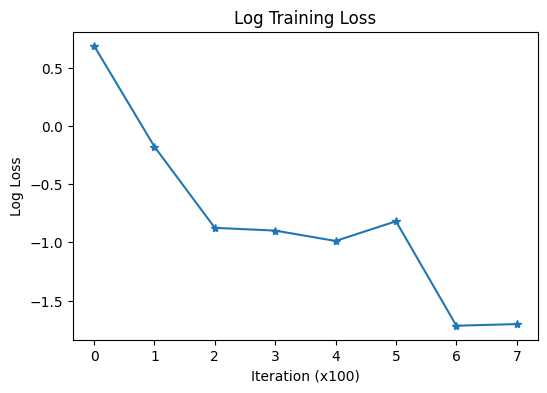

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.90 seconds.
Number of NaN losses encountered: 0


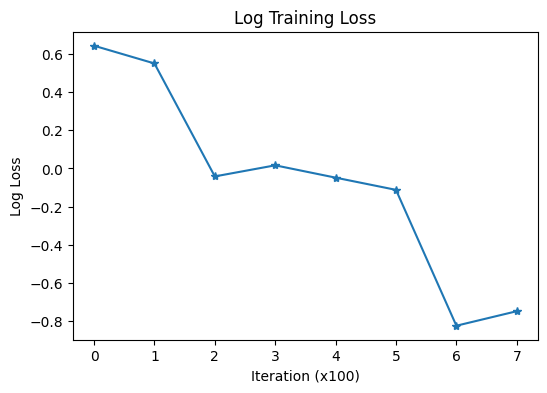

Time step 1 Loss: 1.594365776181221
Time step 0 Loss: 8.32348572731018
Final value at time 0: 36.633522033691406
-----------------------------------------------
Run: 9.0000
Time step 5 Loss: 0.0028730119588726666
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.85 seconds.
Number of NaN losses encountered: 0


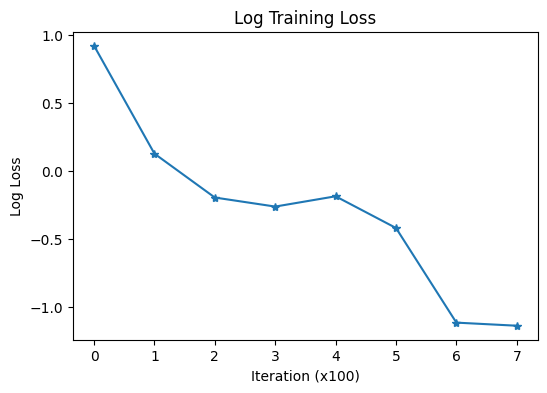

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.97 seconds.
Number of NaN losses encountered: 2


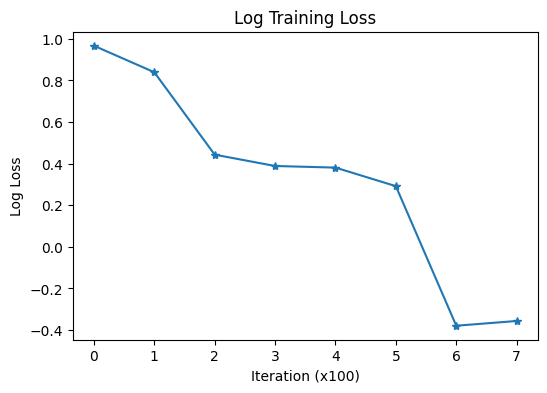

Time step 4 Loss: 3.3849470949172975
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.70 seconds.
Number of NaN losses encountered: 0


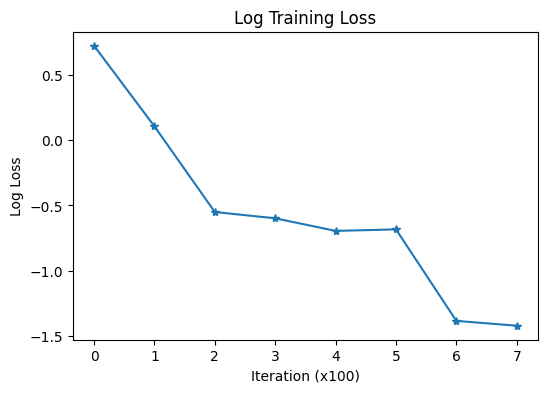

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 13.57 seconds.
Number of NaN losses encountered: 0


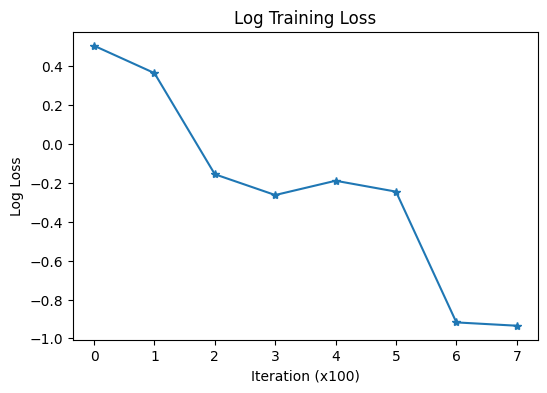

Time step 3 Loss: 2.8078948497772216
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.01 seconds.
Number of NaN losses encountered: 0


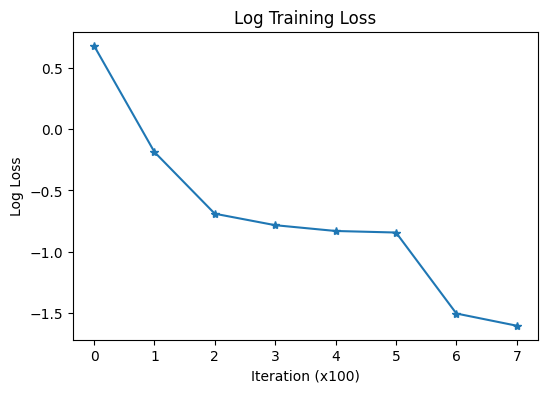

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 11.66 seconds.
Number of NaN losses encountered: 0


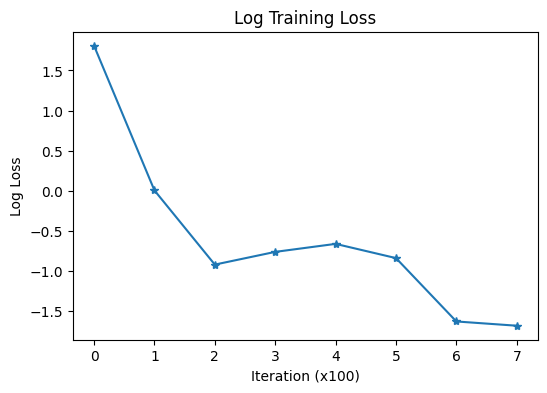

Time step 2 Loss: 14.708767013549805
Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.77 seconds.
Number of NaN losses encountered: 0


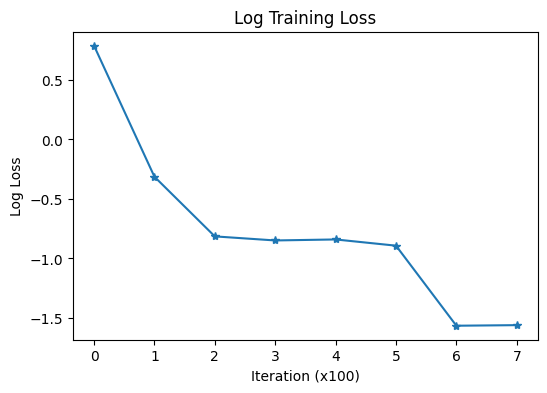

Training progress: 0/749
Training progress: 100/749
Training progress: 200/749
Training progress: 300/749
Training progress: 400/749
Training progress: 500/749
Training progress: 600/749
Training progress: 700/749
Training took 12.96 seconds.
Number of NaN losses encountered: 0


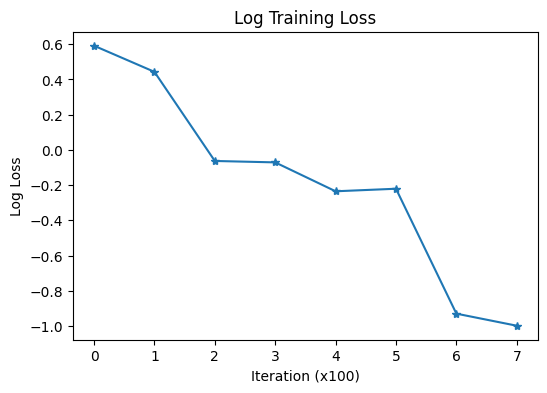

Time step 1 Loss: 1.932524700164795
Time step 0 Loss: 8.133169775009156
Final value at time 0: 35.628780364990234
Average Final Value: 34.3622
Standard Deviation: 1.7767


NameError: name 'distance_squared' is not defined

In [36]:
# Number of runs
num_runs = 10

# Store results
final_values = []
val_histories = []
loss_histories = []

num_paths = 3000

time_steps = 6

# Run the function multiple times
for i in range(num_runs):
    print("-----------------------------------------------")
    print(f"Run: {i:.4f}")
    samplesA = generate_brownian_motion(num_paths=num_paths, x_init=1, time_steps=6, scale=1)
    samplesB = np.random.multivariate_normal(mean, sigma2_pd, size=num_paths)

    samplesB_with_zero = np.hstack([np.zeros((num_paths, 1)), samplesB])
    final_value, val_hist, loss_hist = train_dqn_instance_mult(
        x_dim=1, y_dim=1, time_horizon=time_steps-1,
        samplepath_x=samplesA, samplepath_y=samplesB_with_zero,
        n_opt=50, in_sample_size=10,
        device=device, discount=1, mem_size=3000, trunc_flag=True, n_iter = 750
    )
    
    final_values.append(final_value)
    val_histories.append(val_hist)
    loss_histories.append(loss_hist)

# Compute statistics
final_values = np.array(final_values)
mean_final_value = np.mean(final_values)
std_final_value = np.std(final_values)


# Print results
print(f"Average Final Value: {mean_final_value:.4f}")
print(f"Standard Deviation: {std_final_value:.4f}")
print(f"Comparison with distance_squared: {distance_squared:.4f}")